In [2]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

warnings.filterwarnings('ignore')

### How do variants modulate activity predictions?
Is this aligned with pathogenicity predictors ? Such as alphamissense

Approach: Only focus on tile most centered around variant if there is one

Then: EDA
- Residue changes corresponding with activity prediction changes?
- Plot AlphaMissense score vs predicted activity change
- Activating vs inactivating

---
#### ADPred
1. Find variant vs reference sequence's pred at variant position

In [3]:
# Loading in ADPred files

files = glob.glob("/Users/sanjanakotha/Desktop/Staller_Lab/SFARI/data/adpred_split_variants/*.csv")

all_var_df_list = []
for f in files:
    csv = pd.read_csv(f, index_col = 0)
    all_var_df_list.append(csv)
    
adpred = pd.concat(all_var_df_list)
adpred = adpred.rename(columns = {"id" : "GeneName",
                                     "AAseq" : "ProteinWindowSeq"})
adpred["len"] = adpred["ProteinWindowSeq"].str.len()
adpred = adpred.sort_values(by = "Unnamed: 0")
adpred = adpred.reset_index(drop = True)
adpred

,GeneName,ProteinWindowSeq,position_wise_prob_adpred,Unnamed: 0.1,len
0,GLIS1_Q8NBF1_AD_447-620|g.53506627C>T(p.Asp619...,AESTRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLP...,"[8.08375131e-04,2.06423900e-03,3.40039120e-03,...",NaN,174
1,SRCAP_Q6ZRS2_AD_198-1445|g.30711973A>C(p.Glu54...,MAKDVRQFWSNVEKVVQFKQQSRLEEKRKKALDLHLDFIVGQTEKY...,"[0.00301478,0.00336563,0.00338995,...,0.001278...",600.0,1248
2,GLIS1_Q8NBF1_AD_447-620|g.53506630T>C(p.Thr618...,AESTRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLP...,"[8.08375131e-04,2.06423900e-03,3.40039120e-03,...",NaN,174
3,SRCAP_Q6ZRS2_AD_198-1445|g.30711975G>A(p.Glu54...,MAKDVRQFWSNVEKVVQFKQQSRLEEKRKKALDLHLDFIVGQTEKY...,"[0.00301478,0.00336563,0.00338995,...,0.001278...",601.0,1248
4,SRCAP_Q6ZRS2_AD_198-1445|g.30711977A>T(p.Glu54...,MAKDVRQFWSNVEKVVQFKQQSRLEEKRKKALDLHLDFIVGQTEKY...,"[0.0030299 ,0.00340213,0.00341189,...,0.001278...",602.0,1248
...,...,...,...,...,...
3053,ESR2_Q92731_AD_1-148,MDIKNSPSSLNSPSSYNCSQSILPLEHGSIYIPSSYVDSHHEYPAM...,"[2.43807517e-04,5.13511361e-04,4.61821532e-04,...",NaN,148
3054,ESR2_Q92731_AD_304-500,KELVHMISWAKKIPGFVELSLFDQVRLLESCWMEVLMMGLMWRSID...,"[1.53499190e-03,4.36764583e-03,4.81981738e-03,...",NaN,197
3055,NCOA1_Q15788_AD_1-93,MSGLGDSSSDPANPDSHKRKGSPCDTLASSTEKRRREQENKYLEEL...,"[5.53751073e-04,4.26910730e-04,3.83757026e-04,...",NaN,93
3056,NFE2L3 / NF2L3_Q9Y4A8_AD_252-451,HLNGTDTSFSLEDLFQLLSSQPENSLEGISLGDIPLPGSISDGMNS...,"[9.17278305e-02,1.04091138e-01,1.99391380e-01,...",NaN,200


In [4]:
adpred["GeneName"].iloc[0]

'GLIS1_Q8NBF1_AD_447-620|g.53506627C>T(p.Asp619Asn)'

In [5]:
# Converting string activities to array
def activity_string_to_arr(prob_string, adpred = True):
    if adpred:
        if "..." in prob_string:
            return -1 * np.inf 
    if type(prob_string) != str: 
        print("ERROR, not string")
        print(prob_string)
        return -1 * np.inf
    a = prob_string.replace('\n','')
    a = a.replace('[','')
    a = a.replace(']','').split(',')

        
    b = []
    for x in a:
        if x != "":
            b.append(float(x))
                
    return b

In [6]:
# Extracting info from columns
adpred["position_wise_prob_adpred"] = [activity_string_to_arr(_) for _ in adpred["position_wise_prob_adpred"]]
adpred["var_prot_pos"] = adpred["GeneName"].str.extract(r'p\....(\d+)')
adpred["GeneName"] = adpred["GeneName"].replace({"NFE2L3 / NF2L3_Q9Y4A8_AD_252-451" : "NFE2L3-NF2L3_Q9Y4A8_AD_252-451"})
adpred["AD"] = adpred["GeneName"].str.split("|").str[0]
adpred["AD_start"] = adpred["AD"].str.split("_").str[3].str.split("-").str[0]
adpred["AD_end"] = adpred["AD"].str.split("_").str[3].str.split("-").str[1]
adpred = adpred.fillna(-100000) # WT rows will have a negative var_AD_pos and var_prot_pos
adpred["var_AD_pos"] = adpred["var_prot_pos"].astype(int) - adpred["AD_start"].astype(int)
adpred

,GeneName,ProteinWindowSeq,position_wise_prob_adpred,Unnamed: 0.1,len,var_prot_pos,AD,AD_start,AD_end,var_AD_pos
0,GLIS1_Q8NBF1_AD_447-620|g.53506627C>T(p.Asp619...,AESTRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLP...,"[0.000808375131, 0.002064239, 0.0034003912, 0....",-100000.0,174,619,GLIS1_Q8NBF1_AD_447-620,447,620,172
1,SRCAP_Q6ZRS2_AD_198-1445|g.30711973A>C(p.Glu54...,MAKDVRQFWSNVEKVVQFKQQSRLEEKRKKALDLHLDFIVGQTEKY...,-inf,600.0,1248,544,SRCAP_Q6ZRS2_AD_198-1445,198,1445,346
2,GLIS1_Q8NBF1_AD_447-620|g.53506630T>C(p.Thr618...,AESTRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLP...,"[0.000808375131, 0.002064239, 0.0034003912, 0....",-100000.0,174,618,GLIS1_Q8NBF1_AD_447-620,447,620,171
3,SRCAP_Q6ZRS2_AD_198-1445|g.30711975G>A(p.Glu54...,MAKDVRQFWSNVEKVVQFKQQSRLEEKRKKALDLHLDFIVGQTEKY...,-inf,601.0,1248,545,SRCAP_Q6ZRS2_AD_198-1445,198,1445,347
4,SRCAP_Q6ZRS2_AD_198-1445|g.30711977A>T(p.Glu54...,MAKDVRQFWSNVEKVVQFKQQSRLEEKRKKALDLHLDFIVGQTEKY...,-inf,602.0,1248,545,SRCAP_Q6ZRS2_AD_198-1445,198,1445,347
...,...,...,...,...,...,...,...,...,...,...
3053,ESR2_Q92731_AD_1-148,MDIKNSPSSLNSPSSYNCSQSILPLEHGSIYIPSSYVDSHHEYPAM...,"[0.000243807517, 0.000513511361, 0.00046182153...",-100000.0,148,-100000,ESR2_Q92731_AD_1-148,1,148,-100001
3054,ESR2_Q92731_AD_304-500,KELVHMISWAKKIPGFVELSLFDQVRLLESCWMEVLMMGLMWRSID...,"[0.0015349919, 0.00436764583, 0.00481981738, 0...",-100000.0,197,-100000,ESR2_Q92731_AD_304-500,304,500,-100304
3055,NCOA1_Q15788_AD_1-93,MSGLGDSSSDPANPDSHKRKGSPCDTLASSTEKRRREQENKYLEEL...,"[0.000553751073, 0.00042691073, 0.000383757026...",-100000.0,93,-100000,NCOA1_Q15788_AD_1-93,1,93,-100001
3056,NFE2L3-NF2L3_Q9Y4A8_AD_252-451,HLNGTDTSFSLEDLFQLLSSQPENSLEGISLGDIPLPGSISDGMNS...,"[0.0917278305, 0.104091138, 0.19939138, 0.6622...",-100000.0,200,-100000,NFE2L3-NF2L3_Q9Y4A8_AD_252-451,252,451,-100252


In [7]:
# By AD
adpred_with_var_pred = []

for AD in set(adpred["AD"]):
    print(AD)
    AD_rows = adpred[adpred["AD"] == AD]
    AD_var_rows = AD_rows[AD_rows["GeneName"].str.contains("\|")]
    AD_wt_row = AD_rows[~AD_rows["GeneName"].str.contains("\|")]
    
    var_activities = []
    wt_activities = []
    
    wt_pos_wise = AD_wt_row["position_wise_prob_adpred"].iloc[0]

    if wt_pos_wise != -np.inf:
        for i in AD_var_rows.index:
            row = AD_var_rows.loc[i]
            var_activities.append(row.position_wise_prob_adpred[row.var_AD_pos])
            wt_activities.append(wt_pos_wise[row.var_AD_pos])
            
        AD_var_rows["var_pos_adpred_activity"] = var_activities
        AD_var_rows["ref_pos_adpred_activity"] = wt_activities
        adpred_with_var_pred.append(AD_var_rows)

adpred_with_var_pred = pd.concat(adpred_with_var_pred)
adpred_with_var_pred

TET2_Q6N021_AD_1582-1751
NKX2-2_O95096_AD_220-273
PAX5_Q02548_AD_304-358
NFIA_Q12857_AD_427-509
MEIS2_O14770_AD_340-477
KDM5B_Q9UGL1_AD_1302-1391
ERG_P11308_AD_118-261
MTF1_Q14872_AD_328-509
NCOA1_Q15788_AD_840-1011
TCF4_P15884_AD_340-400
ESR2_Q92731_AD_1-148
NFIX_Q14938_AD_414-502
KLF7_O75840_AD_2-101
EBF3_Q9H4W6_AD_281-360
TFE3_P19532_AD_1-127
TFE3_P19532_AD_212-333
NCOA1_Q15788_AD_1241-1385
YY1_P25490_AD_1-69
NR4A2_P43354_AD_1-91
SMAD4_Q13485_AD_275-552
CAMTA2_O94983_AD_472-581
TCF20_Q9UGU0_AD_1-327
RORA_P35398_AD_272-385
NCOA1_Q15788_AD_1-93
SRCAP_Q6ZRS2_AD_2575-3230
DLX3_O60479_AD_2-91
ESR2_Q92731_AD_304-500
MTF1_Q14872_AD_510-624
OTX1_P32242_AD_172-354
PAX6_P26367_AD_271-422
CASZ1_Q86V15_AD_31-185
TCF4_P15884_AD_1-100
ARNT2_Q9HBZ2_AD_524-717
MEF2C_Q06413_AD_87-473
HIVEP3_Q5T1R4_AD_211-1074
TCF7L2_Q9NQB0_AD_1-53
EGR3_Q06889_AD_13-214
TBX22_Q9Y458_AD_402-481
NR1D1_P20393_AD_8-285
SRCAP_Q6ZRS2_AD_198-1445
MYT1L_Q9UL68_AD_152-425
ARX_Q96QS3_AD_472-562
GLIS1_Q8NBF1_AD_447-620
NFE2L3-N

,GeneName,ProteinWindowSeq,position_wise_prob_adpred,Unnamed: 0.1,len,var_prot_pos,AD,AD_start,AD_end,var_AD_pos,var_pos_adpred_activity,ref_pos_adpred_activity
1990,TET2_Q6N021_AD_1582-1751|g.105275270A>G(p.Asp1...,SSHTSGIYGSTSPMNFYSTSSQAAGSYLNSSNPMNPYPGLLNQNTQ...,"[0.00053041, 0.00165147, 0.00326038, 0.0034795...",-100000.0,170,1587,TET2_Q6N021_AD_1582-1751,1582,1751,5,0.004882,0.008462
1991,TET2_Q6N021_AD_1582-1751|g.105275276A>G(p.Tyr1...,SSHTSDICGSTSPMNFYSTSSQAAGSYLNSSNPMNPYPGLLNQNTQ...,"[0.00055169, 0.00173076, 0.00380862, 0.0042727...",-100000.0,170,1589,TET2_Q6N021_AD_1582-1751,1582,1751,7,0.006776,0.009306
1992,TET2_Q6N021_AD_1582-1751|g.105275281A>T(p.Ser1...,SSHTSDIYGCTSPMNFYSTSSQAAGSYLNSSNPMNPYPGLLNQNTQ...,"[0.00144754, 0.00451254, 0.00941866, 0.0099359...",-100000.0,170,1591,TET2_Q6N021_AD_1582-1751,1582,1751,9,0.010985,0.006337
1993,TET2_Q6N021_AD_1582-1751|g.105275293A>G(p.Met1...,SSHTSDIYGSTSPVNFYSTSSQAAGSYLNSSNPMNPYPGLLNQNTQ...,"[0.0006711, 0.00202642, 0.00400383, 0.00512687...",-100000.0,170,1595,TET2_Q6N021_AD_1582-1751,1582,1751,13,0.015106,0.018903
1994,TET2_Q6N021_AD_1582-1751|g.105275303A>G(p.Tyr1...,SSHTSDIYGSTSPMNFCSTSSQAAGSYLNSSNPMNPYPGLLNQNTQ...,"[0.000782, 0.00247028, 0.00422759, 0.00402325,...",-100000.0,170,1598,TET2_Q6N021_AD_1582-1751,1582,1751,16,0.016320,0.023387
...,...,...,...,...,...,...,...,...,...,...,...,...
1453,CAMTA2_O94983_AD_285-468|g.4980411G>A(p.Pro304...,KAHTSPSSSSSSSSSGFAELLEIRPSPPTSRGGSSRGGTAILLLTG...,"[3.65740852e-05, 3.62961546e-05, 0.00010312100...",-100000.0,184,304,CAMTA2_O94983_AD_285-468,285,468,19,0.002118,0.000883
1454,CAMTA2_O94983_AD_285-468|g.4980418C>A(p.Ala302...,KAHTSPSSSSSSSSSGFSEPLEIRPSPPTSRGGSSRGGTAILLLTG...,"[3.65740852e-05, 3.62961546e-05, 0.00010312100...",-100000.0,184,302,CAMTA2_O94983_AD_285-468,285,468,17,0.000678,0.000648
1455,CAMTA2_O94983_AD_285-468|g.4980451A>G(p.Ser291...,KAHTSPPSSSSSSSSGFAEPLEIRPSPPTSRGGSSRGGTAILLLTG...,"[3.28503302e-05, 3.45399203e-05, 9.46332002e-0...",-100000.0,184,291,CAMTA2_O94983_AD_285-468,285,468,6,0.000284,0.000303
1456,CAMTA2_O94983_AD_285-468|g.4980453G>A(p.Pro290...,KAHTSLSSSSSSSSSGFAEPLEIRPSPPTSRGGSSRGGTAILLLTG...,"[7.84025178e-05, 7.78818721e-05, 0.00023476530...",-100000.0,184,290,CAMTA2_O94983_AD_285-468,285,468,5,0.000271,0.000136


- Residue transitions corresp to activ changes?

In [8]:
adpred_with_var_pred["orig_AA"] = adpred_with_var_pred["GeneName"].str.extract(r'p\.(...)')
adpred_with_var_pred["new_AA"] = adpred_with_var_pred["GeneName"].str[-4:-1]
adpred_with_var_pred

,GeneName,ProteinWindowSeq,position_wise_prob_adpred,Unnamed: 0.1,len,var_prot_pos,AD,AD_start,AD_end,var_AD_pos,var_pos_adpred_activity,ref_pos_adpred_activity,orig_AA,new_AA
1990,TET2_Q6N021_AD_1582-1751|g.105275270A>G(p.Asp1...,SSHTSGIYGSTSPMNFYSTSSQAAGSYLNSSNPMNPYPGLLNQNTQ...,"[0.00053041, 0.00165147, 0.00326038, 0.0034795...",-100000.0,170,1587,TET2_Q6N021_AD_1582-1751,1582,1751,5,0.004882,0.008462,Asp,Gly
1991,TET2_Q6N021_AD_1582-1751|g.105275276A>G(p.Tyr1...,SSHTSDICGSTSPMNFYSTSSQAAGSYLNSSNPMNPYPGLLNQNTQ...,"[0.00055169, 0.00173076, 0.00380862, 0.0042727...",-100000.0,170,1589,TET2_Q6N021_AD_1582-1751,1582,1751,7,0.006776,0.009306,Tyr,Cys
1992,TET2_Q6N021_AD_1582-1751|g.105275281A>T(p.Ser1...,SSHTSDIYGCTSPMNFYSTSSQAAGSYLNSSNPMNPYPGLLNQNTQ...,"[0.00144754, 0.00451254, 0.00941866, 0.0099359...",-100000.0,170,1591,TET2_Q6N021_AD_1582-1751,1582,1751,9,0.010985,0.006337,Ser,Cys
1993,TET2_Q6N021_AD_1582-1751|g.105275293A>G(p.Met1...,SSHTSDIYGSTSPVNFYSTSSQAAGSYLNSSNPMNPYPGLLNQNTQ...,"[0.0006711, 0.00202642, 0.00400383, 0.00512687...",-100000.0,170,1595,TET2_Q6N021_AD_1582-1751,1582,1751,13,0.015106,0.018903,Met,Val
1994,TET2_Q6N021_AD_1582-1751|g.105275303A>G(p.Tyr1...,SSHTSDIYGSTSPMNFCSTSSQAAGSYLNSSNPMNPYPGLLNQNTQ...,"[0.000782, 0.00247028, 0.00422759, 0.00402325,...",-100000.0,170,1598,TET2_Q6N021_AD_1582-1751,1582,1751,16,0.016320,0.023387,Tyr,Cys
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,CAMTA2_O94983_AD_285-468|g.4980411G>A(p.Pro304...,KAHTSPSSSSSSSSSGFAELLEIRPSPPTSRGGSSRGGTAILLLTG...,"[3.65740852e-05, 3.62961546e-05, 0.00010312100...",-100000.0,184,304,CAMTA2_O94983_AD_285-468,285,468,19,0.002118,0.000883,Pro,Leu
1454,CAMTA2_O94983_AD_285-468|g.4980418C>A(p.Ala302...,KAHTSPSSSSSSSSSGFSEPLEIRPSPPTSRGGSSRGGTAILLLTG...,"[3.65740852e-05, 3.62961546e-05, 0.00010312100...",-100000.0,184,302,CAMTA2_O94983_AD_285-468,285,468,17,0.000678,0.000648,Ala,Ser
1455,CAMTA2_O94983_AD_285-468|g.4980451A>G(p.Ser291...,KAHTSPPSSSSSSSSGFAEPLEIRPSPPTSRGGSSRGGTAILLLTG...,"[3.28503302e-05, 3.45399203e-05, 9.46332002e-0...",-100000.0,184,291,CAMTA2_O94983_AD_285-468,285,468,6,0.000284,0.000303,Ser,Pro
1456,CAMTA2_O94983_AD_285-468|g.4980453G>A(p.Pro290...,KAHTSLSSSSSSSSSGFAEPLEIRPSPPTSRGGSSRGGTAILLLTG...,"[7.84025178e-05, 7.78818721e-05, 0.00023476530...",-100000.0,184,290,CAMTA2_O94983_AD_285-468,285,468,5,0.000271,0.000136,Pro,Leu


In [9]:
aa_dict = {
    'Ala': 'A', 'Arg': 'R', 'Asn': 'N', 'Asp': 'D', 'Cys': 'C',
    'Glu': 'E', 'Gln': 'Q', 'Gly': 'G', 'His': 'H', 'Ile': 'I',
    'Leu': 'L', 'Lys': 'K', 'Met': 'M', 'Phe': 'F', 'Pro': 'P',
    'Ser': 'S', 'Thr': 'T', 'Trp': 'W', 'Tyr': 'Y', 'Val': 'V'
}

adpred_with_var_pred["orig_AA"] = adpred_with_var_pred["orig_AA"].map(aa_dict)
adpred_with_var_pred["new_AA"] = adpred_with_var_pred["new_AA"].map(aa_dict)
adpred_with_var_pred

,GeneName,ProteinWindowSeq,position_wise_prob_adpred,Unnamed: 0.1,len,var_prot_pos,AD,AD_start,AD_end,var_AD_pos,var_pos_adpred_activity,ref_pos_adpred_activity,orig_AA,new_AA
1990,TET2_Q6N021_AD_1582-1751|g.105275270A>G(p.Asp1...,SSHTSGIYGSTSPMNFYSTSSQAAGSYLNSSNPMNPYPGLLNQNTQ...,"[0.00053041, 0.00165147, 0.00326038, 0.0034795...",-100000.0,170,1587,TET2_Q6N021_AD_1582-1751,1582,1751,5,0.004882,0.008462,D,G
1991,TET2_Q6N021_AD_1582-1751|g.105275276A>G(p.Tyr1...,SSHTSDICGSTSPMNFYSTSSQAAGSYLNSSNPMNPYPGLLNQNTQ...,"[0.00055169, 0.00173076, 0.00380862, 0.0042727...",-100000.0,170,1589,TET2_Q6N021_AD_1582-1751,1582,1751,7,0.006776,0.009306,Y,C
1992,TET2_Q6N021_AD_1582-1751|g.105275281A>T(p.Ser1...,SSHTSDIYGCTSPMNFYSTSSQAAGSYLNSSNPMNPYPGLLNQNTQ...,"[0.00144754, 0.00451254, 0.00941866, 0.0099359...",-100000.0,170,1591,TET2_Q6N021_AD_1582-1751,1582,1751,9,0.010985,0.006337,S,C
1993,TET2_Q6N021_AD_1582-1751|g.105275293A>G(p.Met1...,SSHTSDIYGSTSPVNFYSTSSQAAGSYLNSSNPMNPYPGLLNQNTQ...,"[0.0006711, 0.00202642, 0.00400383, 0.00512687...",-100000.0,170,1595,TET2_Q6N021_AD_1582-1751,1582,1751,13,0.015106,0.018903,M,V
1994,TET2_Q6N021_AD_1582-1751|g.105275303A>G(p.Tyr1...,SSHTSDIYGSTSPMNFCSTSSQAAGSYLNSSNPMNPYPGLLNQNTQ...,"[0.000782, 0.00247028, 0.00422759, 0.00402325,...",-100000.0,170,1598,TET2_Q6N021_AD_1582-1751,1582,1751,16,0.016320,0.023387,Y,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,CAMTA2_O94983_AD_285-468|g.4980411G>A(p.Pro304...,KAHTSPSSSSSSSSSGFAELLEIRPSPPTSRGGSSRGGTAILLLTG...,"[3.65740852e-05, 3.62961546e-05, 0.00010312100...",-100000.0,184,304,CAMTA2_O94983_AD_285-468,285,468,19,0.002118,0.000883,P,L
1454,CAMTA2_O94983_AD_285-468|g.4980418C>A(p.Ala302...,KAHTSPSSSSSSSSSGFSEPLEIRPSPPTSRGGSSRGGTAILLLTG...,"[3.65740852e-05, 3.62961546e-05, 0.00010312100...",-100000.0,184,302,CAMTA2_O94983_AD_285-468,285,468,17,0.000678,0.000648,A,S
1455,CAMTA2_O94983_AD_285-468|g.4980451A>G(p.Ser291...,KAHTSPPSSSSSSSSGFAEPLEIRPSPPTSRGGSSRGGTAILLLTG...,"[3.28503302e-05, 3.45399203e-05, 9.46332002e-0...",-100000.0,184,291,CAMTA2_O94983_AD_285-468,285,468,6,0.000284,0.000303,S,P
1456,CAMTA2_O94983_AD_285-468|g.4980453G>A(p.Pro290...,KAHTSLSSSSSSSSSGFAEPLEIRPSPPTSRGGSSRGGTAILLLTG...,"[7.84025178e-05, 7.78818721e-05, 0.00023476530...",-100000.0,184,290,CAMTA2_O94983_AD_285-468,285,468,5,0.000271,0.000136,P,L


In [10]:
adpred_with_var_pred["activ_diff_adpred"] = adpred_with_var_pred["var_pos_adpred_activity"] - adpred_with_var_pred["ref_pos_adpred_activity"]
adpred_with_var_pred

,GeneName,ProteinWindowSeq,position_wise_prob_adpred,Unnamed: 0.1,len,var_prot_pos,AD,AD_start,AD_end,var_AD_pos,var_pos_adpred_activity,ref_pos_adpred_activity,orig_AA,new_AA,activ_diff_adpred
1990,TET2_Q6N021_AD_1582-1751|g.105275270A>G(p.Asp1...,SSHTSGIYGSTSPMNFYSTSSQAAGSYLNSSNPMNPYPGLLNQNTQ...,"[0.00053041, 0.00165147, 0.00326038, 0.0034795...",-100000.0,170,1587,TET2_Q6N021_AD_1582-1751,1582,1751,5,0.004882,0.008462,D,G,-0.003580
1991,TET2_Q6N021_AD_1582-1751|g.105275276A>G(p.Tyr1...,SSHTSDICGSTSPMNFYSTSSQAAGSYLNSSNPMNPYPGLLNQNTQ...,"[0.00055169, 0.00173076, 0.00380862, 0.0042727...",-100000.0,170,1589,TET2_Q6N021_AD_1582-1751,1582,1751,7,0.006776,0.009306,Y,C,-0.002530
1992,TET2_Q6N021_AD_1582-1751|g.105275281A>T(p.Ser1...,SSHTSDIYGCTSPMNFYSTSSQAAGSYLNSSNPMNPYPGLLNQNTQ...,"[0.00144754, 0.00451254, 0.00941866, 0.0099359...",-100000.0,170,1591,TET2_Q6N021_AD_1582-1751,1582,1751,9,0.010985,0.006337,S,C,0.004648
1993,TET2_Q6N021_AD_1582-1751|g.105275293A>G(p.Met1...,SSHTSDIYGSTSPVNFYSTSSQAAGSYLNSSNPMNPYPGLLNQNTQ...,"[0.0006711, 0.00202642, 0.00400383, 0.00512687...",-100000.0,170,1595,TET2_Q6N021_AD_1582-1751,1582,1751,13,0.015106,0.018903,M,V,-0.003797
1994,TET2_Q6N021_AD_1582-1751|g.105275303A>G(p.Tyr1...,SSHTSDIYGSTSPMNFCSTSSQAAGSYLNSSNPMNPYPGLLNQNTQ...,"[0.000782, 0.00247028, 0.00422759, 0.00402325,...",-100000.0,170,1598,TET2_Q6N021_AD_1582-1751,1582,1751,16,0.016320,0.023387,Y,C,-0.007067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,CAMTA2_O94983_AD_285-468|g.4980411G>A(p.Pro304...,KAHTSPSSSSSSSSSGFAELLEIRPSPPTSRGGSSRGGTAILLLTG...,"[3.65740852e-05, 3.62961546e-05, 0.00010312100...",-100000.0,184,304,CAMTA2_O94983_AD_285-468,285,468,19,0.002118,0.000883,P,L,0.001236
1454,CAMTA2_O94983_AD_285-468|g.4980418C>A(p.Ala302...,KAHTSPSSSSSSSSSGFSEPLEIRPSPPTSRGGSSRGGTAILLLTG...,"[3.65740852e-05, 3.62961546e-05, 0.00010312100...",-100000.0,184,302,CAMTA2_O94983_AD_285-468,285,468,17,0.000678,0.000648,A,S,0.000030
1455,CAMTA2_O94983_AD_285-468|g.4980451A>G(p.Ser291...,KAHTSPPSSSSSSSSGFAEPLEIRPSPPTSRGGSSRGGTAILLLTG...,"[3.28503302e-05, 3.45399203e-05, 9.46332002e-0...",-100000.0,184,291,CAMTA2_O94983_AD_285-468,285,468,6,0.000284,0.000303,S,P,-0.000019
1456,CAMTA2_O94983_AD_285-468|g.4980453G>A(p.Pro290...,KAHTSLSSSSSSSSSGFAEPLEIRPSPPTSRGGSSRGGTAILLLTG...,"[7.84025178e-05, 7.78818721e-05, 0.00023476530...",-100000.0,184,290,CAMTA2_O94983_AD_285-468,285,468,5,0.000271,0.000136,P,L,0.000134


In [11]:
adpred_results_summary = adpred_with_var_pred[["orig_AA", "new_AA", "activ_diff_adpred"]]
adpred_results_summary

,orig_AA,new_AA,activ_diff_adpred
1990,D,G,-0.003580
1991,Y,C,-0.002530
1992,S,C,0.004648
1993,M,V,-0.003797
1994,Y,C,-0.007067
...,...,...,...
1453,P,L,0.001236
1454,A,S,0.000030
1455,S,P,-0.000019
1456,P,L,0.000134


In [12]:
# Matrix heatmap
adpred_results_summary_avg = adpred_results_summary.groupby(["orig_AA", "new_AA"]).agg(['mean', 'count']).reset_index()
adpred_results_summary_avg.columns = [' '.join(col).strip() for col in adpred_results_summary_avg.columns.values]
adpred_results_summary_avg

,orig_AA,new_AA,activ_diff_adpred mean,activ_diff_adpred count
0,A,D,0.008929,9
1,A,E,0.004104,3
2,A,G,0.000153,16
3,A,P,-0.000459,17
4,A,S,0.000027,31
...,...,...,...,...
138,Y,D,-0.000634,1
139,Y,F,0.041993,5
140,Y,H,-0.031903,10
141,Y,N,-0.008724,3


In [13]:
pivot_adpred_results_summary_avg = pd.pivot(adpred_results_summary_avg, values = "activ_diff_adpred mean", index = "new_AA", columns = "orig_AA")
pivot_adpred_results_summary_avg

orig_AA,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
new_AA,,,,,,,,,,,,,,,,,,,,
A,NaN,NaN,-0.293042,-0.005134,NaN,0.000674,NaN,NaN,NaN,NaN,NaN,NaN,-0.000559,NaN,NaN,-0.000131,0.000692,-0.004326,NaN,NaN
C,NaN,NaN,NaN,NaN,-0.034137,0.030903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.035381,0.005170,NaN,NaN,-0.002610,-0.011574
D,0.008929,NaN,NaN,0.013277,NaN,0.005213,0.073764,NaN,NaN,NaN,NaN,0.025396,NaN,NaN,NaN,NaN,NaN,0.001836,NaN,-0.000634
E,0.004104,NaN,-0.016599,NaN,NaN,0.018469,NaN,NaN,0.076374,NaN,NaN,NaN,NaN,0.011128,NaN,NaN,NaN,-0.000289,NaN,NaN
F,NaN,0.103221,NaN,NaN,NaN,NaN,NaN,0.071470,NaN,0.034861,NaN,NaN,NaN,NaN,NaN,0.084017,NaN,0.041826,NaN,0.041993
G,0.000153,NaN,-0.038593,-0.018526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.052224,0.000108,NaN,-0.008502,-0.119001,NaN
H,NaN,NaN,-0.087844,NaN,NaN,NaN,NaN,NaN,NaN,-0.003947,NaN,-0.004420,-0.002953,-0.002749,0.005650,NaN,NaN,NaN,NaN,-0.031903
I,NaN,NaN,NaN,NaN,-0.004076,NaN,NaN,NaN,NaN,-0.006808,0.000362,0.000787,NaN,NaN,0.004644,0.006331,0.002394,0.018157,NaN,NaN
K,NaN,NaN,NaN,-0.048991,NaN,NaN,NaN,-0.003647,NaN,NaN,-0.001891,-0.007210,NaN,-0.002779,0.002861,NaN,-0.002743,NaN,NaN,NaN


In [14]:
AA_order = ["D", "E", "R", "K", "W", "F", "Y", "L", "M", "I", "V", "A", "S", "T", "N", "Q", "H", "C", "G", "P"]
num_order = np.arange(20)
AA_order_dict = dict(zip(AA_order, num_order))
AA_order_dict

{'D': 0,
 'E': 1,
 'R': 2,
 'K': 3,
 'W': 4,
 'F': 5,
 'Y': 6,
 'L': 7,
 'M': 8,
 'I': 9,
 'V': 10,
 'A': 11,
 'S': 12,
 'T': 13,
 'N': 14,
 'Q': 15,
 'H': 16,
 'C': 17,
 'G': 18,
 'P': 19}

In [15]:
pivot_adpred_results_summary_avg = pivot_adpred_results_summary_avg.reindex(AA_order, axis = 0)
pivot_adpred_results_summary_avg = pivot_adpred_results_summary_avg.reindex(AA_order, axis = 1)
pivot_adpred_results_summary_avg

orig_AA,D,E,R,K,W,F,Y,L,M,I,V,A,S,T,N,Q,H,C,G,P
new_AA,,,,,,,,,,,,,,,,,,,,
D,NaN,0.013277,NaN,NaN,NaN,NaN,-0.000634,NaN,NaN,NaN,0.001836,0.008929,NaN,NaN,0.025396,NaN,0.073764,NaN,0.005213,NaN
E,-0.016599,NaN,NaN,0.076374,NaN,NaN,NaN,NaN,NaN,NaN,-0.000289,0.004104,NaN,NaN,NaN,0.011128,NaN,NaN,0.018469,NaN
R,NaN,NaN,NaN,0.004925,-0.283363,NaN,NaN,-0.125416,-0.007708,NaN,NaN,NaN,-0.028029,-0.003593,NaN,-0.023933,-0.014883,-0.000045,-0.015398,-0.004645
K,NaN,-0.048991,0.002861,NaN,NaN,NaN,NaN,NaN,-0.001891,-0.003647,NaN,NaN,NaN,-0.002743,-0.007210,-0.002779,NaN,NaN,NaN,NaN
W,NaN,NaN,0.076984,NaN,NaN,NaN,NaN,0.004288,NaN,NaN,NaN,NaN,0.167766,NaN,NaN,NaN,NaN,0.000951,0.188584,NaN
F,NaN,NaN,NaN,NaN,NaN,NaN,0.041993,0.034861,NaN,0.071470,0.041826,NaN,0.084017,NaN,NaN,NaN,NaN,0.103221,NaN,NaN
Y,0.011940,NaN,NaN,NaN,NaN,-0.024998,NaN,NaN,NaN,NaN,NaN,NaN,0.038590,NaN,0.005052,NaN,0.044019,0.007365,NaN,NaN
L,NaN,NaN,0.035664,NaN,NaN,-0.023748,NaN,NaN,0.006187,0.002474,0.032339,NaN,0.019414,NaN,NaN,0.043016,0.000164,NaN,NaN,0.013544
M,NaN,NaN,NaN,0.121130,NaN,NaN,NaN,-0.002975,NaN,-0.000100,0.003976,NaN,NaN,0.026856,NaN,NaN,NaN,NaN,NaN,NaN


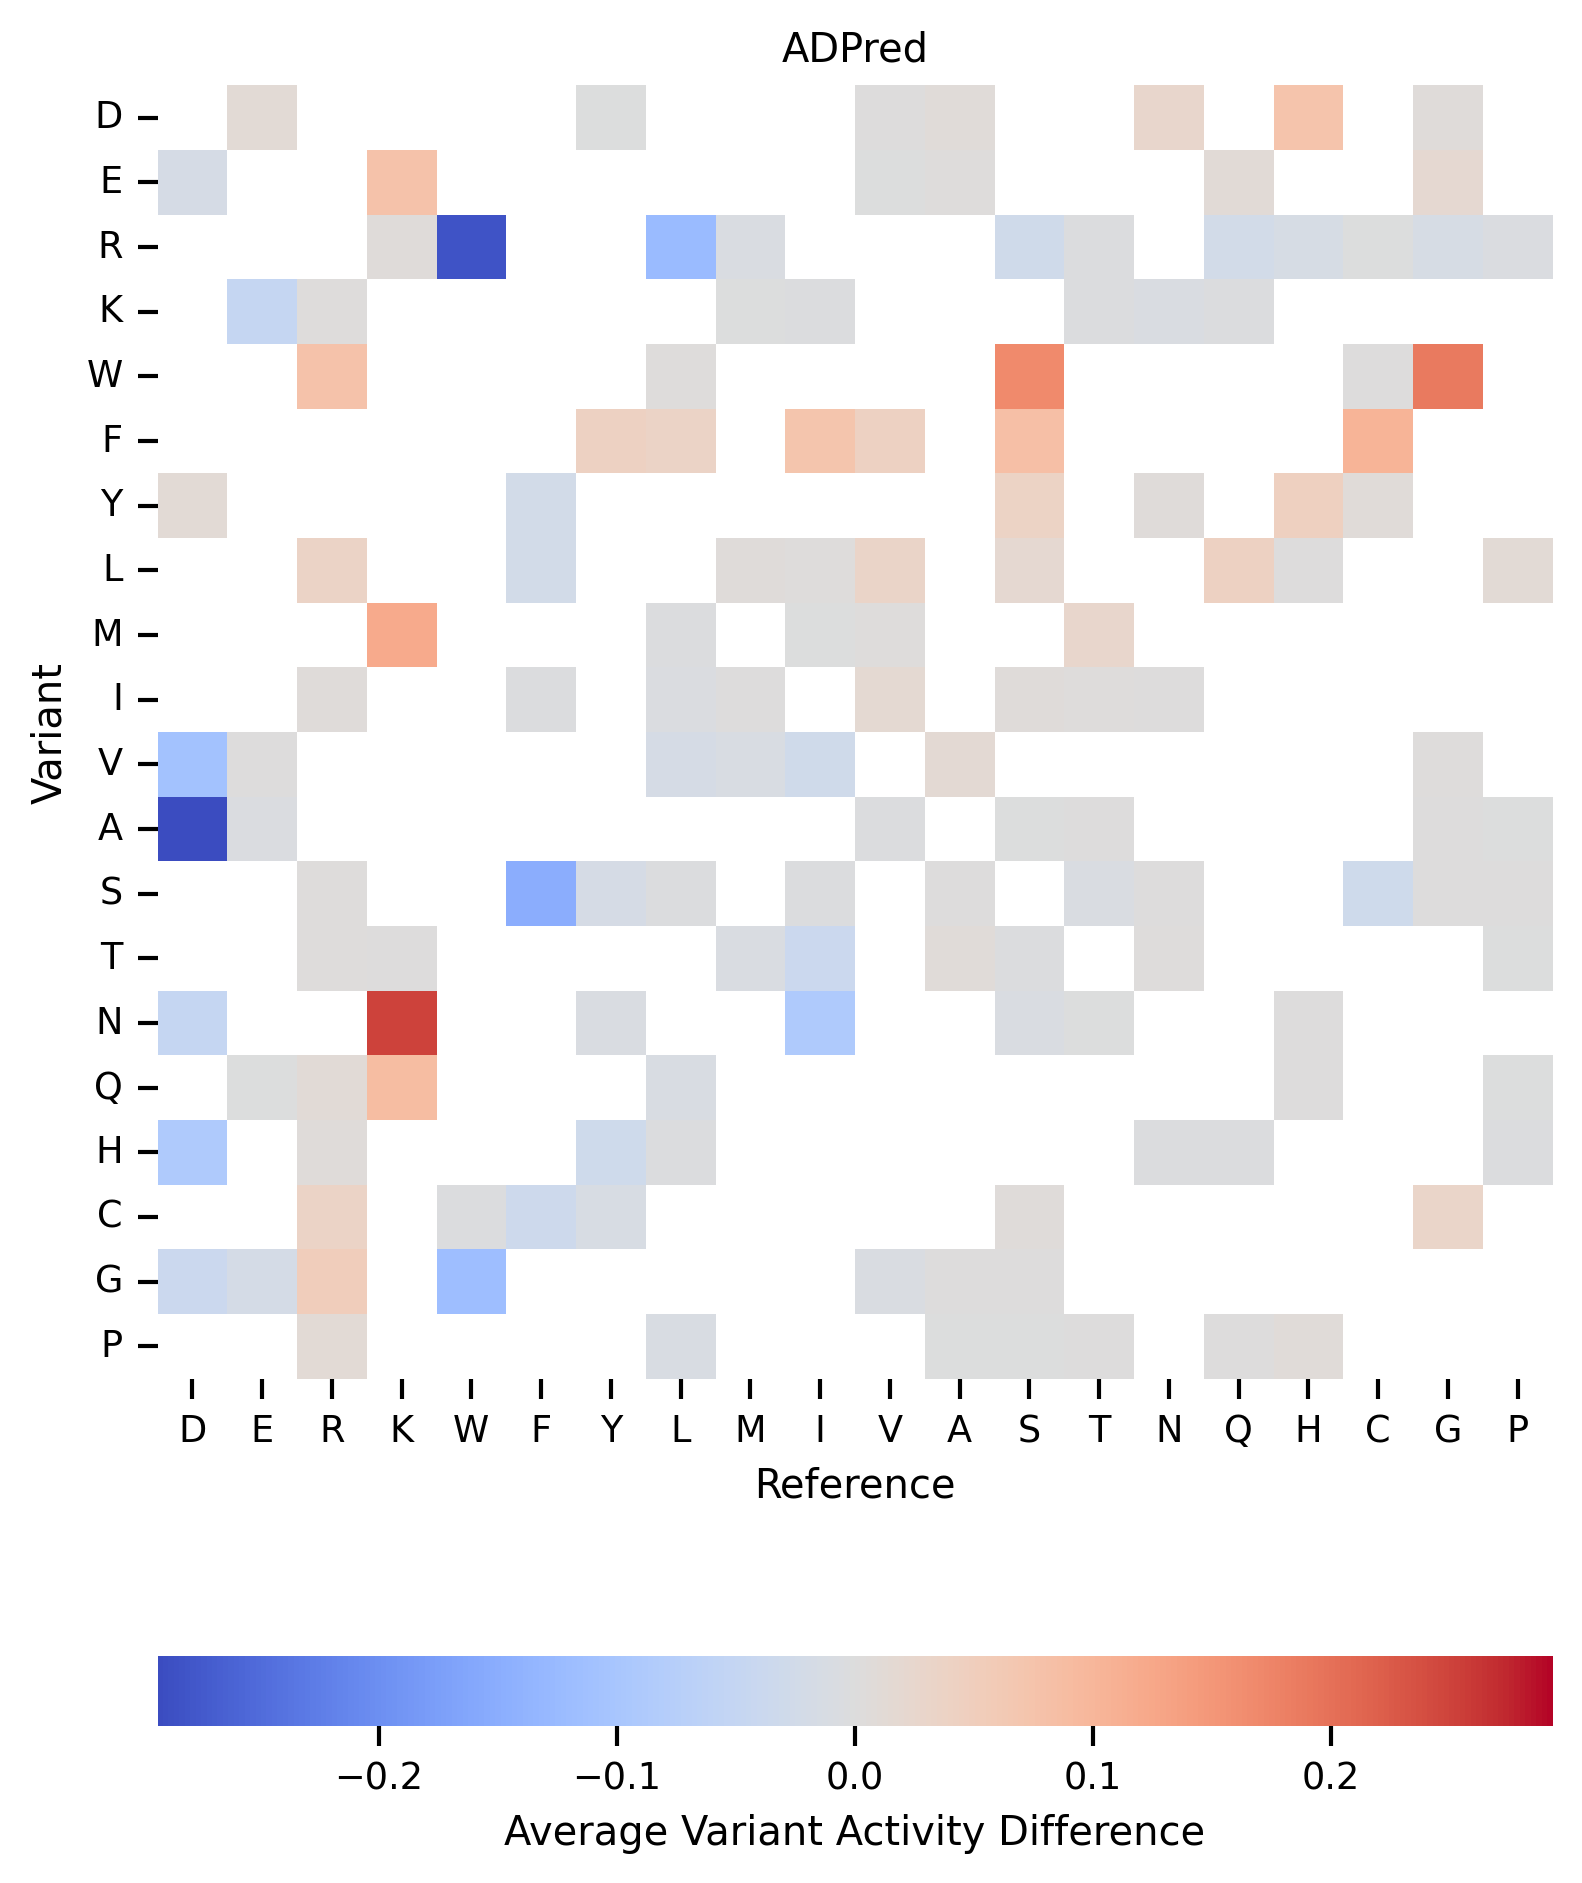

In [16]:
sns.set_context('paper')
cmap_bound = max(abs(max(adpred_results_summary_avg["activ_diff_adpred mean"])),abs(min(adpred_results_summary_avg["activ_diff_adpred mean"])))
fig, ax = plt.subplots(figsize=(6, 8), dpi = 300)
sns.heatmap(pivot_adpred_results_summary_avg, ax = ax, 
            cmap = "coolwarm", 
            vmin = -1 * cmap_bound, 
            vmax = cmap_bound, 
            cbar_kws = dict(location="bottom", label = "Average Variant Activity Difference"))
plt.yticks(rotation = 0)
plt.title("ADPred");
plt.xlabel("Reference")
plt.ylabel("Variant");

In [17]:
pivot_adpred_count = pd.pivot(adpred_results_summary_avg, values = "activ_diff_adpred count", index = "new_AA", columns = "orig_AA")
pivot_adpred_count = pivot_adpred_count.reindex(AA_order, axis = 0)
pivot_adpred_count = pivot_adpred_count.reindex(AA_order, axis = 1)
pivot_adpred_count

orig_AA,D,E,R,K,W,F,Y,L,M,I,V,A,S,T,N,Q,H,C,G,P
new_AA,,,,,,,,,,,,,,,,,,,,
D,NaN,30.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,9.0,NaN,NaN,16.0,NaN,3.0,NaN,21.0,NaN
E,38.0,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,NaN,NaN,NaN,22.0,NaN,NaN,17.0,NaN
R,NaN,NaN,NaN,11.0,1.0,NaN,NaN,7.0,5.0,NaN,NaN,NaN,26.0,5.0,NaN,31.0,22.0,2.0,55.0,30.0
K,NaN,52.0,15.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,NaN,NaN,NaN,9.0,13.0,8.0,NaN,NaN,NaN,NaN
W,NaN,NaN,36.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,1.0,3.0,NaN
F,NaN,NaN,NaN,NaN,NaN,NaN,5.0,28.0,NaN,6.0,6.0,NaN,21.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN
Y,11.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,NaN,5.0,NaN,20.0,9.0,NaN,NaN
L,NaN,NaN,15.0,NaN,NaN,9.0,NaN,NaN,19.0,9.0,20.0,NaN,36.0,NaN,NaN,12.0,2.0,NaN,NaN,123.0
M,NaN,NaN,NaN,3.0,NaN,NaN,NaN,11.0,NaN,9.0,30.0,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
pivot_adpred_results_summary_avg

orig_AA,D,E,R,K,W,F,Y,L,M,I,V,A,S,T,N,Q,H,C,G,P
new_AA,,,,,,,,,,,,,,,,,,,,
D,NaN,0.013277,NaN,NaN,NaN,NaN,-0.000634,NaN,NaN,NaN,0.001836,0.008929,NaN,NaN,0.025396,NaN,0.073764,NaN,0.005213,NaN
E,-0.016599,NaN,NaN,0.076374,NaN,NaN,NaN,NaN,NaN,NaN,-0.000289,0.004104,NaN,NaN,NaN,0.011128,NaN,NaN,0.018469,NaN
R,NaN,NaN,NaN,0.004925,-0.283363,NaN,NaN,-0.125416,-0.007708,NaN,NaN,NaN,-0.028029,-0.003593,NaN,-0.023933,-0.014883,-0.000045,-0.015398,-0.004645
K,NaN,-0.048991,0.002861,NaN,NaN,NaN,NaN,NaN,-0.001891,-0.003647,NaN,NaN,NaN,-0.002743,-0.007210,-0.002779,NaN,NaN,NaN,NaN
W,NaN,NaN,0.076984,NaN,NaN,NaN,NaN,0.004288,NaN,NaN,NaN,NaN,0.167766,NaN,NaN,NaN,NaN,0.000951,0.188584,NaN
F,NaN,NaN,NaN,NaN,NaN,NaN,0.041993,0.034861,NaN,0.071470,0.041826,NaN,0.084017,NaN,NaN,NaN,NaN,0.103221,NaN,NaN
Y,0.011940,NaN,NaN,NaN,NaN,-0.024998,NaN,NaN,NaN,NaN,NaN,NaN,0.038590,NaN,0.005052,NaN,0.044019,0.007365,NaN,NaN
L,NaN,NaN,0.035664,NaN,NaN,-0.023748,NaN,NaN,0.006187,0.002474,0.032339,NaN,0.019414,NaN,NaN,0.043016,0.000164,NaN,NaN,0.013544
M,NaN,NaN,NaN,0.121130,NaN,NaN,NaN,-0.002975,NaN,-0.000100,0.003976,NaN,NaN,0.026856,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
adpred_results_summary_avg['orig_AA'] = adpred_results_summary_avg['orig_AA'].map(dict(zip(AA_order, np.arange(20))))
adpred_results_summary_avg['new_AA'] = 20 - adpred_results_summary_avg['new_AA'].map(dict(zip(AA_order, np.arange(20))))
adpred_results_summary_avg# = adpred_results_summary_avg.

,orig_AA,new_AA,activ_diff_adpred mean,activ_diff_adpred count
0,11,20,0.008929,9
1,11,19,0.004104,3
2,11,2,0.000153,16
3,11,1,-0.000459,17
4,11,8,0.000027,31
...,...,...,...,...
138,6,20,-0.000634,1
139,6,15,0.041993,5
140,6,4,-0.031903,10
141,6,6,-0.008724,3


Text(0.5, 1.0, 'ADPred')

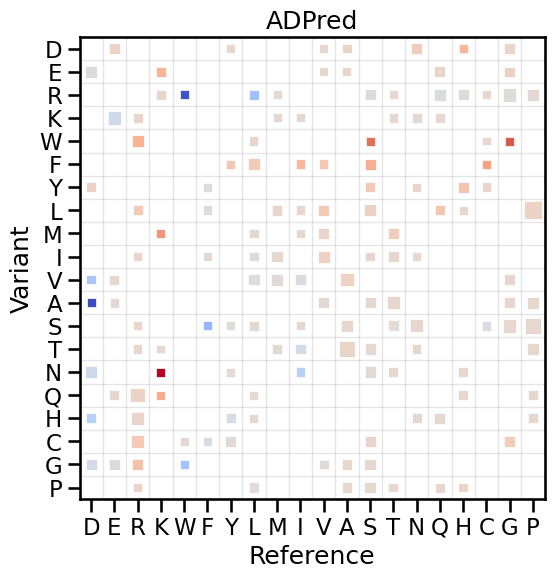

In [20]:
sns.set_context('talk')
plt.figure(figsize=(6, 6))


cmap_bound = max(abs(max(adpred_results_summary_avg["activ_diff_adpred mean"])),
                 abs(min(adpred_results_summary_avg["activ_diff_adpred mean"])))

# Normalize the 'activ_diff_adpred mean' values
adpred_results_summary_avg['normalized_mean'] = (
    adpred_results_summary_avg['activ_diff_adpred mean'] - cmap_bound
) / (2 * cmap_bound)  # Normalization to the range [-1, 1]

sns.scatterplot(
    data=adpred_results_summary_avg,
    x="orig_AA",
    y="new_AA",
    hue="normalized_mean",  # Color by mean activity difference
    size="activ_diff_adpred count",  # Size by count
    #sizes=(50, 260),  # Define a size range for the markers
    palette="coolwarm",  # Use the coolwarm colormap
    #legend="full"  # Show the full legend
    legend = False,
    marker = "s"
)
plt.yticks(np.arange(21), labels = [""] + list(reversed(AA_order)));
plt.xticks(np.arange(20), labels = AA_order);
plt.ylim(0.5, 20.5)
plt.xlim(-0.5, 19.5)

for i in np.arange(20):
    plt.axvline(i + 0.5, color = "black", alpha = 0.1, linewidth = 1)
    plt.axhline(i + 0.5, color = "black", alpha = 0.1, linewidth = 1)

plt.xlabel("Reference")
plt.ylabel("Variant");
plt.title("ADPred")

---
#### PADDLE

In [21]:
paddle_long = pd.read_csv("../output/PADDLE_noSS_SFARI_Variants_output.csv", index_col = 0)
paddle_long

,id,AAseq,tiled_sequences,paddle_noSS_pred
0,GLIS1_Q8NBF1_AD_447-620|g.53506627C>T(p.Asp619...,AESTRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLP...,AESTRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLP...,-0.042140
1,GLIS1_Q8NBF1_AD_447-620|g.53506627C>T(p.Asp619...,AESTRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLP...,ESTRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLPS...,0.090035
2,GLIS1_Q8NBF1_AD_447-620|g.53506627C>T(p.Asp619...,AESTRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLP...,STRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLPSK...,0.045005
3,GLIS1_Q8NBF1_AD_447-620|g.53506627C>T(p.Asp619...,AESTRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLP...,TRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLPSKP...,0.011374
4,GLIS1_Q8NBF1_AD_447-620|g.53506627C>T(p.Asp619...,AESTRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLP...,RDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLPSKPS...,0.027149
...,...,...,...,...
1209888,TFE3_P19532_AD_472-575,PGAATFHVGGGPAQNAPHQQPPAPPSDALLDLHFPSDHLGDLGDPF...,LGLEDILMEEEEGVVGGLSGGALSPLRAASDPLLSSVSPAVSKASS...,0.872204
1209889,TFE3_P19532_AD_472-575,PGAATFHVGGGPAQNAPHQQPPAPPSDALLDLHFPSDHLGDLGDPF...,GLEDILMEEEEGVVGGLSGGALSPLRAASDPLLSSVSPAVSKASSR...,0.902151
1209890,TFE3_P19532_AD_472-575,PGAATFHVGGGPAQNAPHQQPPAPPSDALLDLHFPSDHLGDLGDPF...,LEDILMEEEEGVVGGLSGGALSPLRAASDPLLSSVSPAVSKASSRR...,0.893960
1209891,TFE3_P19532_AD_472-575,PGAATFHVGGGPAQNAPHQQPPAPPSDALLDLHFPSDHLGDLGDPF...,EDILMEEEEGVVGGLSGGALSPLRAASDPLLSSVSPAVSKASSRRS...,0.410317


Tiled sequences are 53AA

So 26 to left of variant and 26 to right of variant ideally

In [22]:
tile_starts = []

for i in paddle_long.index:
    tile_starts.append(paddle_long["AAseq"].loc[i].find(paddle_long["tiled_sequences"].loc[i]))

paddle_long["tile_start"] = tile_starts
paddle_long

,id,AAseq,tiled_sequences,paddle_noSS_pred,tile_start
0,GLIS1_Q8NBF1_AD_447-620|g.53506627C>T(p.Asp619...,AESTRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLP...,AESTRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLP...,-0.042140,0
1,GLIS1_Q8NBF1_AD_447-620|g.53506627C>T(p.Asp619...,AESTRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLP...,ESTRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLPS...,0.090035,1
2,GLIS1_Q8NBF1_AD_447-620|g.53506627C>T(p.Asp619...,AESTRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLP...,STRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLPSK...,0.045005,2
3,GLIS1_Q8NBF1_AD_447-620|g.53506627C>T(p.Asp619...,AESTRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLP...,TRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLPSKP...,0.011374,3
4,GLIS1_Q8NBF1_AD_447-620|g.53506627C>T(p.Asp619...,AESTRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLP...,RDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLPSKPS...,0.027149,4
...,...,...,...,...,...
1209888,TFE3_P19532_AD_472-575,PGAATFHVGGGPAQNAPHQQPPAPPSDALLDLHFPSDHLGDLGDPF...,LGLEDILMEEEEGVVGGLSGGALSPLRAASDPLLSSVSPAVSKASS...,0.872204,47
1209889,TFE3_P19532_AD_472-575,PGAATFHVGGGPAQNAPHQQPPAPPSDALLDLHFPSDHLGDLGDPF...,GLEDILMEEEEGVVGGLSGGALSPLRAASDPLLSSVSPAVSKASSR...,0.902151,48
1209890,TFE3_P19532_AD_472-575,PGAATFHVGGGPAQNAPHQQPPAPPSDALLDLHFPSDHLGDLGDPF...,LEDILMEEEEGVVGGLSGGALSPLRAASDPLLSSVSPAVSKASSRR...,0.893960,49
1209891,TFE3_P19532_AD_472-575,PGAATFHVGGGPAQNAPHQQPPAPPSDALLDLHFPSDHLGDLGDPF...,EDILMEEEEGVVGGLSGGALSPLRAASDPLLSSVSPAVSKASSRRS...,0.410317,50


In [23]:
# Extracting info from columns
paddle_long["var_prot_pos"] = paddle_long["id"].str.extract(r'p\....(\d+)')
paddle_long["id"] = paddle_long["id"].replace({"NFE2L3 / NF2L3_Q9Y4A8_AD_252-451" : "NFE2L3-NF2L3_Q9Y4A8_AD_252-451"})
paddle_long["AD"] = paddle_long["id"].str.split("|").str[0]
paddle_long["AD_start"] = paddle_long["AD"].str.split("_").str[3].str.split("-").str[0]
paddle_long["AD_end"] = paddle_long["AD"].str.split("_").str[3].str.split("-").str[1]
paddle_long = paddle_long.fillna(-100000) # WT rows will have a negative var_AD_pos and var_prot_pos
paddle_long["var_AD_pos"] = paddle_long["var_prot_pos"].astype(int) - paddle_long["AD_start"].astype(int)
paddle_long["tile_center"] = paddle_long["tile_start"] + 22
paddle_long["var_center_dist"] = np.abs(paddle_long["var_AD_pos"] - paddle_long["tile_center"])
paddle_long

,id,AAseq,tiled_sequences,paddle_noSS_pred,tile_start,var_prot_pos,AD,AD_start,AD_end,var_AD_pos,tile_center,var_center_dist
0,GLIS1_Q8NBF1_AD_447-620|g.53506627C>T(p.Asp619...,AESTRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLP...,AESTRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLP...,-0.042140,0,619,GLIS1_Q8NBF1_AD_447-620,447,620,172,22,150
1,GLIS1_Q8NBF1_AD_447-620|g.53506627C>T(p.Asp619...,AESTRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLP...,ESTRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLPS...,0.090035,1,619,GLIS1_Q8NBF1_AD_447-620,447,620,172,23,149
2,GLIS1_Q8NBF1_AD_447-620|g.53506627C>T(p.Asp619...,AESTRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLP...,STRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLPSK...,0.045005,2,619,GLIS1_Q8NBF1_AD_447-620,447,620,172,24,148
3,GLIS1_Q8NBF1_AD_447-620|g.53506627C>T(p.Asp619...,AESTRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLP...,TRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLPSKP...,0.011374,3,619,GLIS1_Q8NBF1_AD_447-620,447,620,172,25,147
4,GLIS1_Q8NBF1_AD_447-620|g.53506627C>T(p.Asp619...,AESTRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLP...,RDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLPSKPS...,0.027149,4,619,GLIS1_Q8NBF1_AD_447-620,447,620,172,26,146
...,...,...,...,...,...,...,...,...,...,...,...,...
1209888,TFE3_P19532_AD_472-575,PGAATFHVGGGPAQNAPHQQPPAPPSDALLDLHFPSDHLGDLGDPF...,LGLEDILMEEEEGVVGGLSGGALSPLRAASDPLLSSVSPAVSKASS...,0.872204,47,-100000,TFE3_P19532_AD_472-575,472,575,-100472,69,100541
1209889,TFE3_P19532_AD_472-575,PGAATFHVGGGPAQNAPHQQPPAPPSDALLDLHFPSDHLGDLGDPF...,GLEDILMEEEEGVVGGLSGGALSPLRAASDPLLSSVSPAVSKASSR...,0.902151,48,-100000,TFE3_P19532_AD_472-575,472,575,-100472,70,100542
1209890,TFE3_P19532_AD_472-575,PGAATFHVGGGPAQNAPHQQPPAPPSDALLDLHFPSDHLGDLGDPF...,LEDILMEEEEGVVGGLSGGALSPLRAASDPLLSSVSPAVSKASSRR...,0.893960,49,-100000,TFE3_P19532_AD_472-575,472,575,-100472,71,100543
1209891,TFE3_P19532_AD_472-575,PGAATFHVGGGPAQNAPHQQPPAPPSDALLDLHFPSDHLGDLGDPF...,EDILMEEEEGVVGGLSGGALSPLRAASDPLLSSVSPAVSKASSRRS...,0.410317,50,-100000,TFE3_P19532_AD_472-575,472,575,-100472,72,100544


In [24]:
paddle_closest_tile = []

for AD in list(set(paddle_long["AD"])):
    AD_rows = paddle_long[paddle_long["AD"] == AD]
    wt_rows = AD_rows[~AD_rows["id"].str.contains(">")]
    var_rows = AD_rows[AD_rows["id"].str.contains(">")]

    var_names = []
    var_preds = []
    wt_preds = []
    
    for var in list(set(var_rows["id"])):
        one_var_rows = var_rows[var_rows["id"] == var]
        closest_center_row = one_var_rows.sort_values(by = "var_center_dist").iloc[0]
        if closest_center_row["var_center_dist"] > 53:
            print("ERROR too far")

        var_names.append(var)
        var_preds.append(closest_center_row["paddle_noSS_pred"])
        wt_preds.append(wt_rows[wt_rows["tile_center"] == closest_center_row["tile_center"]]["paddle_noSS_pred"].iloc[0])
            
    AD_results = pd.DataFrame({"var" : var_names, "var_pred": var_preds, "wt_pred" : wt_preds})
    paddle_closest_tile.append(AD_results)

paddle_closest_tile = pd.concat(paddle_closest_tile)
paddle_closest_tile

,var,var_pred,wt_pred
0,TET2_Q6N021_AD_1582-1751|g.105275545T>C(p.Tyr1...,0.278393,0.257930
1,TET2_Q6N021_AD_1582-1751|g.105275735C>A(p.Pro1...,0.776625,0.967611
2,TET2_Q6N021_AD_1582-1751|g.105275599G>A(p.Gly1...,0.025680,0.134452
3,TET2_Q6N021_AD_1582-1751|g.105275677C>T(p.Pro1...,0.877722,0.967611
4,TET2_Q6N021_AD_1582-1751|g.105275350C>T(p.Pro1...,1.447820,1.383659
...,...,...,...
62,CAMTA2_O94983_AD_285-468|g.4979929G>T(p.Pro465...,0.043928,0.078846
63,CAMTA2_O94983_AD_285-468|g.4980262T>C(p.Met354...,0.114723,0.157701
64,CAMTA2_O94983_AD_285-468|g.4980169G>C(p.Gln385...,0.950107,0.698398
65,CAMTA2_O94983_AD_285-468|g.4979953C>T(p.Gly457...,0.040427,0.078846


In [25]:
paddle_closest_tile["orig_AA"] = paddle_closest_tile["var"].str.extract(r'p\.(...)')
paddle_closest_tile["new_AA"] = paddle_closest_tile["var"].str[-4:-1]
paddle_closest_tile["orig_AA"] = paddle_closest_tile["orig_AA"].map(aa_dict)
paddle_closest_tile["new_AA"] = paddle_closest_tile["new_AA"].map(aa_dict)
paddle_closest_tile["activ_diff_paddle"] = paddle_closest_tile["var_pred"] - paddle_closest_tile["wt_pred"]
paddle_closest_tile

,var,var_pred,wt_pred,orig_AA,new_AA,activ_diff_paddle
0,TET2_Q6N021_AD_1582-1751|g.105275545T>C(p.Tyr1...,0.278393,0.257930,Y,H,0.020463
1,TET2_Q6N021_AD_1582-1751|g.105275735C>A(p.Pro1...,0.776625,0.967611,P,H,-0.190986
2,TET2_Q6N021_AD_1582-1751|g.105275599G>A(p.Gly1...,0.025680,0.134452,G,R,-0.108773
3,TET2_Q6N021_AD_1582-1751|g.105275677C>T(p.Pro1...,0.877722,0.967611,P,S,-0.089889
4,TET2_Q6N021_AD_1582-1751|g.105275350C>T(p.Pro1...,1.447820,1.383659,P,S,0.064161
...,...,...,...,...,...,...
62,CAMTA2_O94983_AD_285-468|g.4979929G>T(p.Pro465...,0.043928,0.078846,P,T,-0.034918
63,CAMTA2_O94983_AD_285-468|g.4980262T>C(p.Met354...,0.114723,0.157701,M,V,-0.042978
64,CAMTA2_O94983_AD_285-468|g.4980169G>C(p.Gln385...,0.950107,0.698398,Q,E,0.251709
65,CAMTA2_O94983_AD_285-468|g.4979953C>T(p.Gly457...,0.040427,0.078846,G,R,-0.038419


In [26]:
paddle_results_summary = paddle_closest_tile[["orig_AA", "new_AA", "activ_diff_paddle"]]
paddle_results_summary

,orig_AA,new_AA,activ_diff_paddle
0,Y,H,0.020463
1,P,H,-0.190986
2,G,R,-0.108773
3,P,S,-0.089889
4,P,S,0.064161
...,...,...,...
62,P,T,-0.034918
63,M,V,-0.042978
64,Q,E,0.251709
65,G,R,-0.038419


In [27]:
# Matrix heatmap
paddle_results_summary_avg = paddle_results_summary.groupby(["orig_AA", "new_AA"]).agg(np.mean).reset_index()
paddle_results_summary_avg

,orig_AA,new_AA,activ_diff_paddle
0,A,D,0.210569
1,A,E,0.260471
2,A,G,0.038074
3,A,P,-0.000410
4,A,S,0.043346
...,...,...,...
139,Y,D,-0.031954
140,Y,F,0.124197
141,Y,H,-0.102076
142,Y,N,-0.318362


In [28]:
pivot_paddle_results_summary_avg = pd.pivot(paddle_results_summary_avg, values = "activ_diff_paddle", index = "new_AA", columns = "orig_AA")
pivot_paddle_results_summary_avg = pivot_paddle_results_summary_avg.reindex(AA_order, axis = 0)
pivot_paddle_results_summary_avg = pivot_paddle_results_summary_avg.reindex(AA_order, axis = 1)
pivot_paddle_results_summary_avg

orig_AA,D,E,R,K,W,F,Y,L,M,I,V,A,S,T,N,Q,H,C,G,P
new_AA,,,,,,,,,,,,,,,,,,,,
D,NaN,0.027367,NaN,NaN,NaN,NaN,-0.031954,NaN,NaN,NaN,0.763653,0.210569,NaN,NaN,0.164832,NaN,0.692240,NaN,0.161156,NaN
E,-0.027746,NaN,NaN,0.302828,NaN,NaN,NaN,NaN,NaN,NaN,-0.114178,0.260471,NaN,NaN,NaN,0.185546,NaN,NaN,0.116894,NaN
R,NaN,NaN,NaN,-0.016001,-0.059791,NaN,NaN,-0.272145,-0.328283,NaN,NaN,NaN,-0.228939,-0.166301,NaN,-0.295540,-0.179109,-0.026518,-0.225227,-0.142613
K,NaN,-0.287915,-0.013833,NaN,NaN,NaN,NaN,NaN,-0.289321,-0.348171,NaN,NaN,NaN,-0.082430,-0.218169,-0.255940,NaN,NaN,NaN,NaN
W,NaN,NaN,0.327416,NaN,NaN,NaN,NaN,0.449694,NaN,NaN,NaN,NaN,0.184076,NaN,NaN,NaN,NaN,0.042234,0.582898,NaN
F,NaN,NaN,NaN,NaN,NaN,NaN,0.124197,0.154010,NaN,0.248277,0.197987,NaN,0.228935,NaN,NaN,NaN,NaN,0.612441,NaN,NaN
Y,-0.206127,NaN,NaN,NaN,NaN,-0.093316,NaN,NaN,NaN,NaN,NaN,NaN,0.215531,NaN,-0.161174,NaN,0.092243,0.200084,NaN,NaN
L,NaN,NaN,0.279741,NaN,NaN,-0.178460,NaN,NaN,0.010683,0.027809,0.071081,NaN,0.021043,NaN,NaN,-0.070948,-0.202702,NaN,NaN,0.021208
M,NaN,NaN,NaN,0.026655,NaN,NaN,NaN,-0.007654,NaN,0.044956,0.052864,NaN,NaN,0.021337,NaN,NaN,NaN,NaN,NaN,NaN


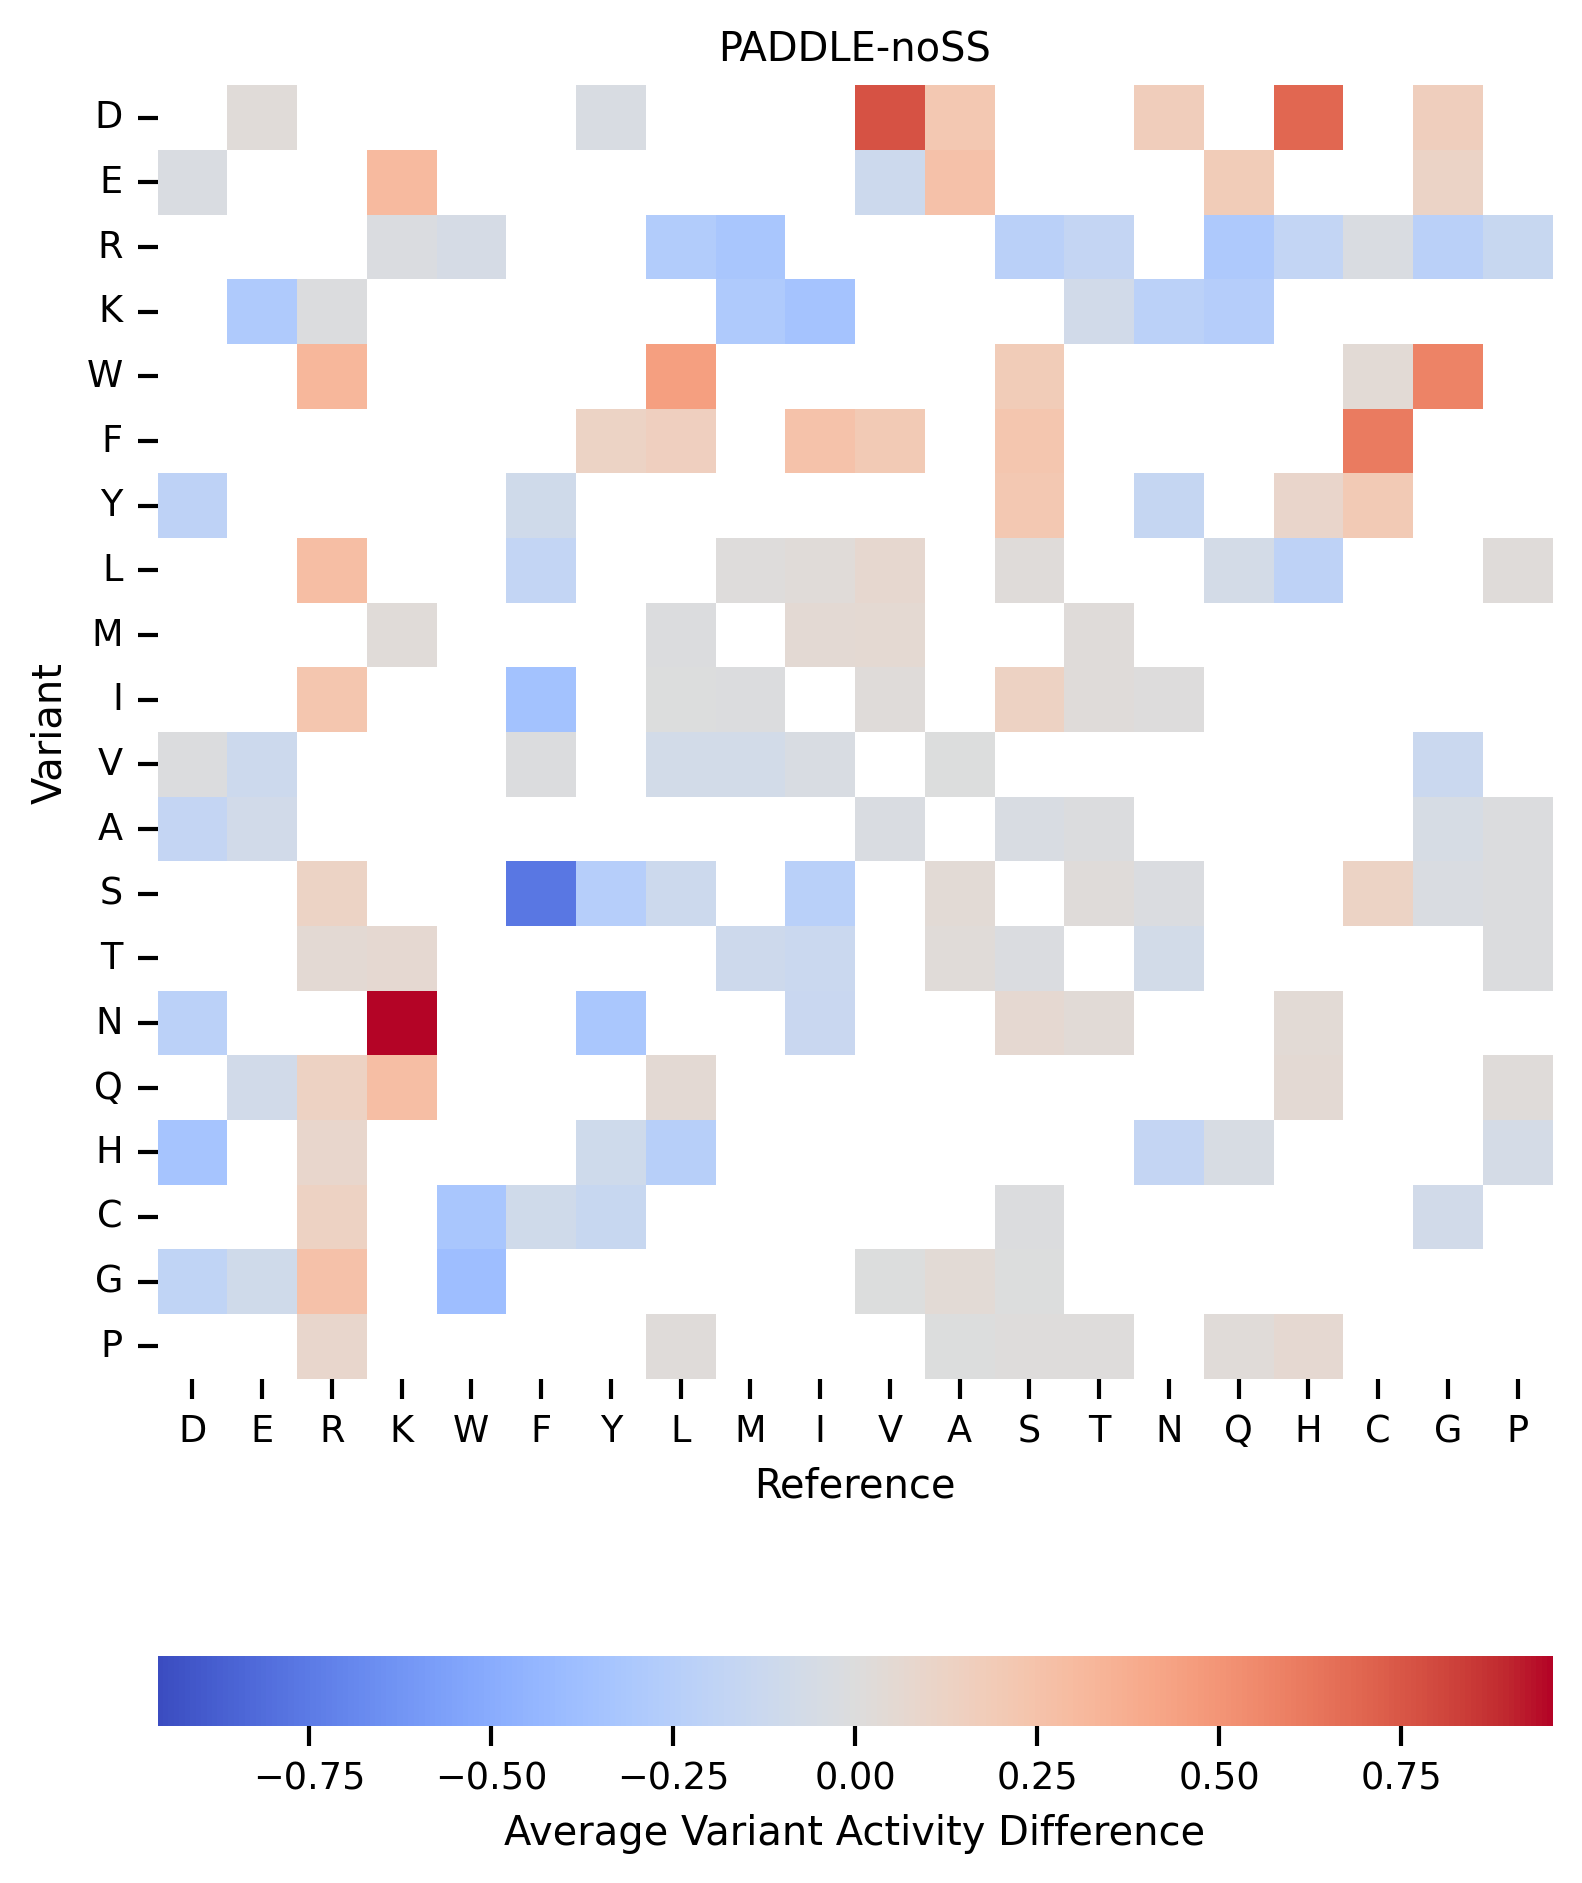

In [29]:
sns.set_context('paper')
cmap_bound = max(abs(max(paddle_results_summary_avg["activ_diff_paddle"])),abs(min(paddle_results_summary_avg["activ_diff_paddle"])))
fig, ax = plt.subplots(figsize=(6, 8), dpi = 300)

sns.heatmap(pivot_paddle_results_summary_avg, ax = ax, cmap = "coolwarm", vmin = -1 * cmap_bound, vmax = cmap_bound, cbar_kws = dict(location="bottom", label = "Average Variant Activity Difference"))
plt.title("PADDLE-noSS");
plt.yticks(rotation = 0)
plt.xlabel("Reference")
plt.ylabel("Variant");

---
#### ADHunter

In [30]:
adhunter_raw_var = pd.read_csv("../data/adhunter_preds.csv", index_col = 0)
adhunter_raw_wt = pd.read_csv("../data/wt_adhunter_preds.csv", index_col = 0)
adhunter_raw = pd.concat([adhunter_raw_var, adhunter_raw_wt])
adhunter_raw["seq"] = adhunter_raw["sequence"]
adhunter_raw = adhunter_raw[["seq", "adhunter_centers", "adhunter_preds"]]
adhunter_raw

,seq,adhunter_centers,adhunter_preds
0,AESTRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLP...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[25452.94140625, 23765.2734375, 26750.62890625..."
1,AESTRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLP...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[25452.94140625, 23765.2734375, 26750.62890625..."
2,AESTRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLP...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[25452.94140625, 23765.2734375, 26750.62890625..."
3,AESTRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLP...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[25452.94140625, 23765.2734375, 26750.62890625..."
4,AESTRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLP...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[25452.94140625, 23765.2734375, 26750.62890625..."
...,...,...,...
43,MDIKNSPSSLNSPSSYNCSQSILPLEHGSIYIPSSYVDSHHEYPAM...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[47500.36328125, 33817.86328125, 34415.9101562..."
44,KELVHMISWAKKIPGFVELSLFDQVRLLESCWMEVLMMGLMWRSID...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[136944.125, 138582.296875, 128650.828125, 110..."
45,MSGLGDSSSDPANPDSHKRKGSPCDTLASSTEKRRREQENKYLEEL...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[21515.88671875, 22503.74609375, 29914.3710937..."
46,HLNGTDTSFSLEDLFQLLSSQPENSLEGISLGDIPLPGSISDGMNS...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[125187.0625, 131845.1875, 117697.8203125, 111..."


In [31]:
adhunter = pd.merge(adpred[["GeneName", "ProteinWindowSeq"]], adhunter_raw, left_on = "ProteinWindowSeq", right_on = "seq", how = "left")
adhunter

,GeneName,ProteinWindowSeq,seq,adhunter_centers,adhunter_preds
0,GLIS1_Q8NBF1_AD_447-620|g.53506627C>T(p.Asp619...,AESTRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLP...,AESTRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLP...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[25452.94140625, 23765.2734375, 26750.62890625..."
1,SRCAP_Q6ZRS2_AD_198-1445|g.30711973A>C(p.Glu54...,MAKDVRQFWSNVEKVVQFKQQSRLEEKRKKALDLHLDFIVGQTEKY...,MAKDVRQFWSNVEKVVQFKQQSRLEEKRKKALDLHLDFIVGQTEKY...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[54763.7890625, 49217.28515625, 50351.39453125..."
2,GLIS1_Q8NBF1_AD_447-620|g.53506630T>C(p.Thr618...,AESTRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLP...,AESTRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLP...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[25452.94140625, 23765.2734375, 26750.62890625..."
3,SRCAP_Q6ZRS2_AD_198-1445|g.30711975G>A(p.Glu54...,MAKDVRQFWSNVEKVVQFKQQSRLEEKRKKALDLHLDFIVGQTEKY...,MAKDVRQFWSNVEKVVQFKQQSRLEEKRKKALDLHLDFIVGQTEKY...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[54763.7890625, 49217.28515625, 50351.39453125..."
4,SRCAP_Q6ZRS2_AD_198-1445|g.30711977A>T(p.Glu54...,MAKDVRQFWSNVEKVVQFKQQSRLEEKRKKALDLHLDFIVGQTEKY...,MAKDVRQFWSNVEKVVQFKQQSRLEEKRKKALDLHLDFIVGQTEKY...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[54763.7890625, 49217.28515625, 50351.39453125..."
...,...,...,...,...,...
3091,ESR2_Q92731_AD_1-148,MDIKNSPSSLNSPSSYNCSQSILPLEHGSIYIPSSYVDSHHEYPAM...,MDIKNSPSSLNSPSSYNCSQSILPLEHGSIYIPSSYVDSHHEYPAM...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[47500.36328125, 33817.86328125, 34415.9101562..."
3092,ESR2_Q92731_AD_304-500,KELVHMISWAKKIPGFVELSLFDQVRLLESCWMEVLMMGLMWRSID...,KELVHMISWAKKIPGFVELSLFDQVRLLESCWMEVLMMGLMWRSID...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[136944.125, 138582.296875, 128650.828125, 110..."
3093,NCOA1_Q15788_AD_1-93,MSGLGDSSSDPANPDSHKRKGSPCDTLASSTEKRRREQENKYLEEL...,MSGLGDSSSDPANPDSHKRKGSPCDTLASSTEKRRREQENKYLEEL...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[21515.88671875, 22503.74609375, 29914.3710937..."
3094,NFE2L3-NF2L3_Q9Y4A8_AD_252-451,HLNGTDTSFSLEDLFQLLSSQPENSLEGISLGDIPLPGSISDGMNS...,HLNGTDTSFSLEDLFQLLSSQPENSLEGISLGDIPLPGSISDGMNS...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[125187.0625, 131845.1875, 117697.8203125, 111..."


In [32]:
# Extracting info from columns
adhunter["position_wise_prob_adhunter"] = [activity_string_to_arr(_) for _ in adhunter["adhunter_preds"]]
adhunter["adhunter_centers"] = [activity_string_to_arr(_) for _ in adhunter["adhunter_centers"]]
adhunter["var_prot_pos"] = adhunter["GeneName"].str.extract(r'p\....(\d+)')
adhunter["GeneName"] = adhunter["GeneName"].replace({"NFE2L3 / NF2L3_Q9Y4A8_AD_252-451" : "NFE2L3-NF2L3_Q9Y4A8_AD_252-451"})
adhunter["AD"] = adhunter["GeneName"].str.split("|").str[0]
adhunter["AD_start"] = adhunter["AD"].str.split("_").str[3].str.split("-").str[0]
adhunter["AD_end"] = adhunter["AD"].str.split("_").str[3].str.split("-").str[1]
adhunter = adhunter.fillna(-100000) # WT rows will have a negative var_AD_pos and var_prot_pos
adhunter["var_AD_pos"] = adhunter["var_prot_pos"].astype(int) - adhunter["AD_start"].astype(int)
adhunter

,GeneName,ProteinWindowSeq,seq,adhunter_centers,adhunter_preds,position_wise_prob_adhunter,var_prot_pos,AD,AD_start,AD_end,var_AD_pos
0,GLIS1_Q8NBF1_AD_447-620|g.53506627C>T(p.Asp619...,AESTRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLP...,AESTRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLP...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[25452.94140625, 23765.2734375, 26750.62890625...","[25452.94140625, 23765.2734375, 26750.62890625...",619,GLIS1_Q8NBF1_AD_447-620,447,620,172
1,SRCAP_Q6ZRS2_AD_198-1445|g.30711973A>C(p.Glu54...,MAKDVRQFWSNVEKVVQFKQQSRLEEKRKKALDLHLDFIVGQTEKY...,MAKDVRQFWSNVEKVVQFKQQSRLEEKRKKALDLHLDFIVGQTEKY...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[54763.7890625, 49217.28515625, 50351.39453125...","[54763.7890625, 49217.28515625, 50351.39453125...",544,SRCAP_Q6ZRS2_AD_198-1445,198,1445,346
2,GLIS1_Q8NBF1_AD_447-620|g.53506630T>C(p.Thr618...,AESTRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLP...,AESTRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLP...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[25452.94140625, 23765.2734375, 26750.62890625...","[25452.94140625, 23765.2734375, 26750.62890625...",618,GLIS1_Q8NBF1_AD_447-620,447,620,171
3,SRCAP_Q6ZRS2_AD_198-1445|g.30711975G>A(p.Glu54...,MAKDVRQFWSNVEKVVQFKQQSRLEEKRKKALDLHLDFIVGQTEKY...,MAKDVRQFWSNVEKVVQFKQQSRLEEKRKKALDLHLDFIVGQTEKY...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[54763.7890625, 49217.28515625, 50351.39453125...","[54763.7890625, 49217.28515625, 50351.39453125...",545,SRCAP_Q6ZRS2_AD_198-1445,198,1445,347
4,SRCAP_Q6ZRS2_AD_198-1445|g.30711977A>T(p.Glu54...,MAKDVRQFWSNVEKVVQFKQQSRLEEKRKKALDLHLDFIVGQTEKY...,MAKDVRQFWSNVEKVVQFKQQSRLEEKRKKALDLHLDFIVGQTEKY...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[54763.7890625, 49217.28515625, 50351.39453125...","[54763.7890625, 49217.28515625, 50351.39453125...",545,SRCAP_Q6ZRS2_AD_198-1445,198,1445,347
...,...,...,...,...,...,...,...,...,...,...,...
3091,ESR2_Q92731_AD_1-148,MDIKNSPSSLNSPSSYNCSQSILPLEHGSIYIPSSYVDSHHEYPAM...,MDIKNSPSSLNSPSSYNCSQSILPLEHGSIYIPSSYVDSHHEYPAM...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[47500.36328125, 33817.86328125, 34415.9101562...","[47500.36328125, 33817.86328125, 34415.9101562...",-100000,ESR2_Q92731_AD_1-148,1,148,-100001
3092,ESR2_Q92731_AD_304-500,KELVHMISWAKKIPGFVELSLFDQVRLLESCWMEVLMMGLMWRSID...,KELVHMISWAKKIPGFVELSLFDQVRLLESCWMEVLMMGLMWRSID...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[136944.125, 138582.296875, 128650.828125, 110...","[136944.125, 138582.296875, 128650.828125, 110...",-100000,ESR2_Q92731_AD_304-500,304,500,-100304
3093,NCOA1_Q15788_AD_1-93,MSGLGDSSSDPANPDSHKRKGSPCDTLASSTEKRRREQENKYLEEL...,MSGLGDSSSDPANPDSHKRKGSPCDTLASSTEKRRREQENKYLEEL...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[21515.88671875, 22503.74609375, 29914.3710937...","[21515.88671875, 22503.74609375, 29914.3710937...",-100000,NCOA1_Q15788_AD_1-93,1,93,-100001
3094,NFE2L3-NF2L3_Q9Y4A8_AD_252-451,HLNGTDTSFSLEDLFQLLSSQPENSLEGISLGDIPLPGSISDGMNS...,HLNGTDTSFSLEDLFQLLSSQPENSLEGISLGDIPLPGSISDGMNS...,"[20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27....","[125187.0625, 131845.1875, 117697.8203125, 111...","[125187.0625, 131845.1875, 117697.8203125, 111...",-100000,NFE2L3-NF2L3_Q9Y4A8_AD_252-451,252,451,-100252


In [33]:
adhunter_expanded = adhunter.explode(["adhunter_centers", "position_wise_prob_adhunter"])
adhunter_expanded["var_center_dist"] = np.abs(adhunter_expanded["var_AD_pos"] - adhunter_expanded["adhunter_centers"])
adhunter_expanded

,GeneName,ProteinWindowSeq,seq,adhunter_centers,adhunter_preds,position_wise_prob_adhunter,var_prot_pos,AD,AD_start,AD_end,var_AD_pos,var_center_dist
0,GLIS1_Q8NBF1_AD_447-620|g.53506627C>T(p.Asp619...,AESTRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLP...,AESTRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLP...,20.0,"[25452.94140625, 23765.2734375, 26750.62890625...",25452.941406,619,GLIS1_Q8NBF1_AD_447-620,447,620,172,152.0
0,GLIS1_Q8NBF1_AD_447-620|g.53506627C>T(p.Asp619...,AESTRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLP...,AESTRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLP...,21.0,"[25452.94140625, 23765.2734375, 26750.62890625...",23765.273438,619,GLIS1_Q8NBF1_AD_447-620,447,620,172,151.0
0,GLIS1_Q8NBF1_AD_447-620|g.53506627C>T(p.Asp619...,AESTRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLP...,AESTRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLP...,22.0,"[25452.94140625, 23765.2734375, 26750.62890625...",26750.628906,619,GLIS1_Q8NBF1_AD_447-620,447,620,172,150.0
0,GLIS1_Q8NBF1_AD_447-620|g.53506627C>T(p.Asp619...,AESTRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLP...,AESTRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLP...,23.0,"[25452.94140625, 23765.2734375, 26750.62890625...",23906.207031,619,GLIS1_Q8NBF1_AD_447-620,447,620,172,149.0
0,GLIS1_Q8NBF1_AD_447-620|g.53506627C>T(p.Asp619...,AESTRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLP...,AESTRDGLGPGLLSPIVSPLKGLGPPPLPPSSQSHSPGGQPFPTLP...,24.0,"[25452.94140625, 23765.2734375, 26750.62890625...",26141.078125,619,GLIS1_Q8NBF1_AD_447-620,447,620,172,148.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3095,TFE3_P19532_AD_472-575,PGAATFHVGGGPAQNAPHQQPPAPPSDALLDLHFPSDHLGDLGDPF...,PGAATFHVGGGPAQNAPHQQPPAPPSDALLDLHFPSDHLGDLGDPF...,80.0,"[77328.65625, 54568.80078125, 70456.71875, 842...",39072.058594,-100000,TFE3_P19532_AD_472-575,472,575,-100472,100552.0
3095,TFE3_P19532_AD_472-575,PGAATFHVGGGPAQNAPHQQPPAPPSDALLDLHFPSDHLGDLGDPF...,PGAATFHVGGGPAQNAPHQQPPAPPSDALLDLHFPSDHLGDLGDPF...,81.0,"[77328.65625, 54568.80078125, 70456.71875, 842...",35719.617188,-100000,TFE3_P19532_AD_472-575,472,575,-100472,100553.0
3095,TFE3_P19532_AD_472-575,PGAATFHVGGGPAQNAPHQQPPAPPSDALLDLHFPSDHLGDLGDPF...,PGAATFHVGGGPAQNAPHQQPPAPPSDALLDLHFPSDHLGDLGDPF...,82.0,"[77328.65625, 54568.80078125, 70456.71875, 842...",33156.386719,-100000,TFE3_P19532_AD_472-575,472,575,-100472,100554.0
3095,TFE3_P19532_AD_472-575,PGAATFHVGGGPAQNAPHQQPPAPPSDALLDLHFPSDHLGDLGDPF...,PGAATFHVGGGPAQNAPHQQPPAPPSDALLDLHFPSDHLGDLGDPF...,83.0,"[77328.65625, 54568.80078125, 70456.71875, 842...",22777.109375,-100000,TFE3_P19532_AD_472-575,472,575,-100472,100555.0


In [34]:
adhunter_closest_tile = []

for AD in list(set(adhunter_expanded["AD"])):
    AD_rows = adhunter_expanded[adhunter_expanded["AD"] == AD]
    wt_rows = AD_rows[~AD_rows["GeneName"].str.contains(">")]
    var_rows = AD_rows[AD_rows["GeneName"].str.contains(">")]

    var_names = []
    var_preds = []
    wt_preds = []
    
    for var in list(set(var_rows["GeneName"])):
        one_var_rows = var_rows[var_rows["GeneName"] == var]
        closest_center_row = one_var_rows.sort_values(by = "var_center_dist").iloc[0]
        #print(closest_center_row["var_center_dist"])
        
        if closest_center_row["var_center_dist"] > 20:
            print("ERROR too far")

        var_names.append(var)
        var_preds.append(closest_center_row["position_wise_prob_adhunter"])
        wt_preds.append(wt_rows[wt_rows["adhunter_centers"] == closest_center_row["adhunter_centers"]]["position_wise_prob_adhunter"].iloc[0])
            
    AD_results = pd.DataFrame({"var" : var_names, "var_pred": var_preds, "wt_pred" : wt_preds})
    adhunter_closest_tile.append(AD_results)

adhunter_closest_tile = pd.concat(adhunter_closest_tile)
adhunter_closest_tile

,var,var_pred,wt_pred
0,TET2_Q6N021_AD_1582-1751|g.105275545T>C(p.Tyr1...,34170.109375,37560.636719
1,TET2_Q6N021_AD_1582-1751|g.105275735C>A(p.Pro1...,58852.671875,60707.257812
2,TET2_Q6N021_AD_1582-1751|g.105275599G>A(p.Gly1...,58617.785156,61002.683594
3,TET2_Q6N021_AD_1582-1751|g.105275677C>T(p.Pro1...,53091.054688,53002.324219
4,TET2_Q6N021_AD_1582-1751|g.105275350C>T(p.Pro1...,56997.199219,60133.660156
...,...,...,...
62,CAMTA2_O94983_AD_285-468|g.4979929G>T(p.Pro465...,34826.765625,31639.273438
63,CAMTA2_O94983_AD_285-468|g.4980262T>C(p.Met354...,20906.359375,22100.820312
64,CAMTA2_O94983_AD_285-468|g.4980169G>C(p.Gln385...,27991.976562,28169.351562
65,CAMTA2_O94983_AD_285-468|g.4979953C>T(p.Gly457...,28410.824219,31639.273438


In [35]:
adhunter_closest_tile["orig_AA"] = adhunter_closest_tile["var"].str.extract(r'p\.(...)')
adhunter_closest_tile["new_AA"] = adhunter_closest_tile["var"].str[-4:-1]
adhunter_closest_tile["orig_AA"] = adhunter_closest_tile["orig_AA"].map(aa_dict)
adhunter_closest_tile["new_AA"] = adhunter_closest_tile["new_AA"].map(aa_dict)
adhunter_closest_tile["activ_diff_adhunter"] = adhunter_closest_tile["var_pred"] - adhunter_closest_tile["wt_pred"]
adhunter_results_summary = adhunter_closest_tile[["orig_AA", "new_AA", "activ_diff_adhunter"]]
adhunter_results_summary

,orig_AA,new_AA,activ_diff_adhunter
0,Y,H,-3390.527344
1,P,H,-1854.585938
2,G,R,-2384.898438
3,P,S,88.730469
4,P,S,-3136.460938
...,...,...,...
62,P,T,3187.492188
63,M,V,-1194.460938
64,Q,E,-177.375000
65,G,R,-3228.449219


In [36]:
# Matrix heatmap
adhunter_results_summary_avg = adhunter_results_summary.groupby(["orig_AA", "new_AA"]).agg(np.mean).reset_index()
adhunter_results_summary_avg

,orig_AA,new_AA,activ_diff_adhunter
0,A,D,4835.516927
1,A,E,6607.691406
2,A,G,-151.670573
3,A,P,-821.702734
4,A,S,-1388.499414
...,...,...,...
139,Y,D,-1747.054688
140,Y,F,4323.586719
141,Y,H,-6726.673503
142,Y,N,-23553.691406


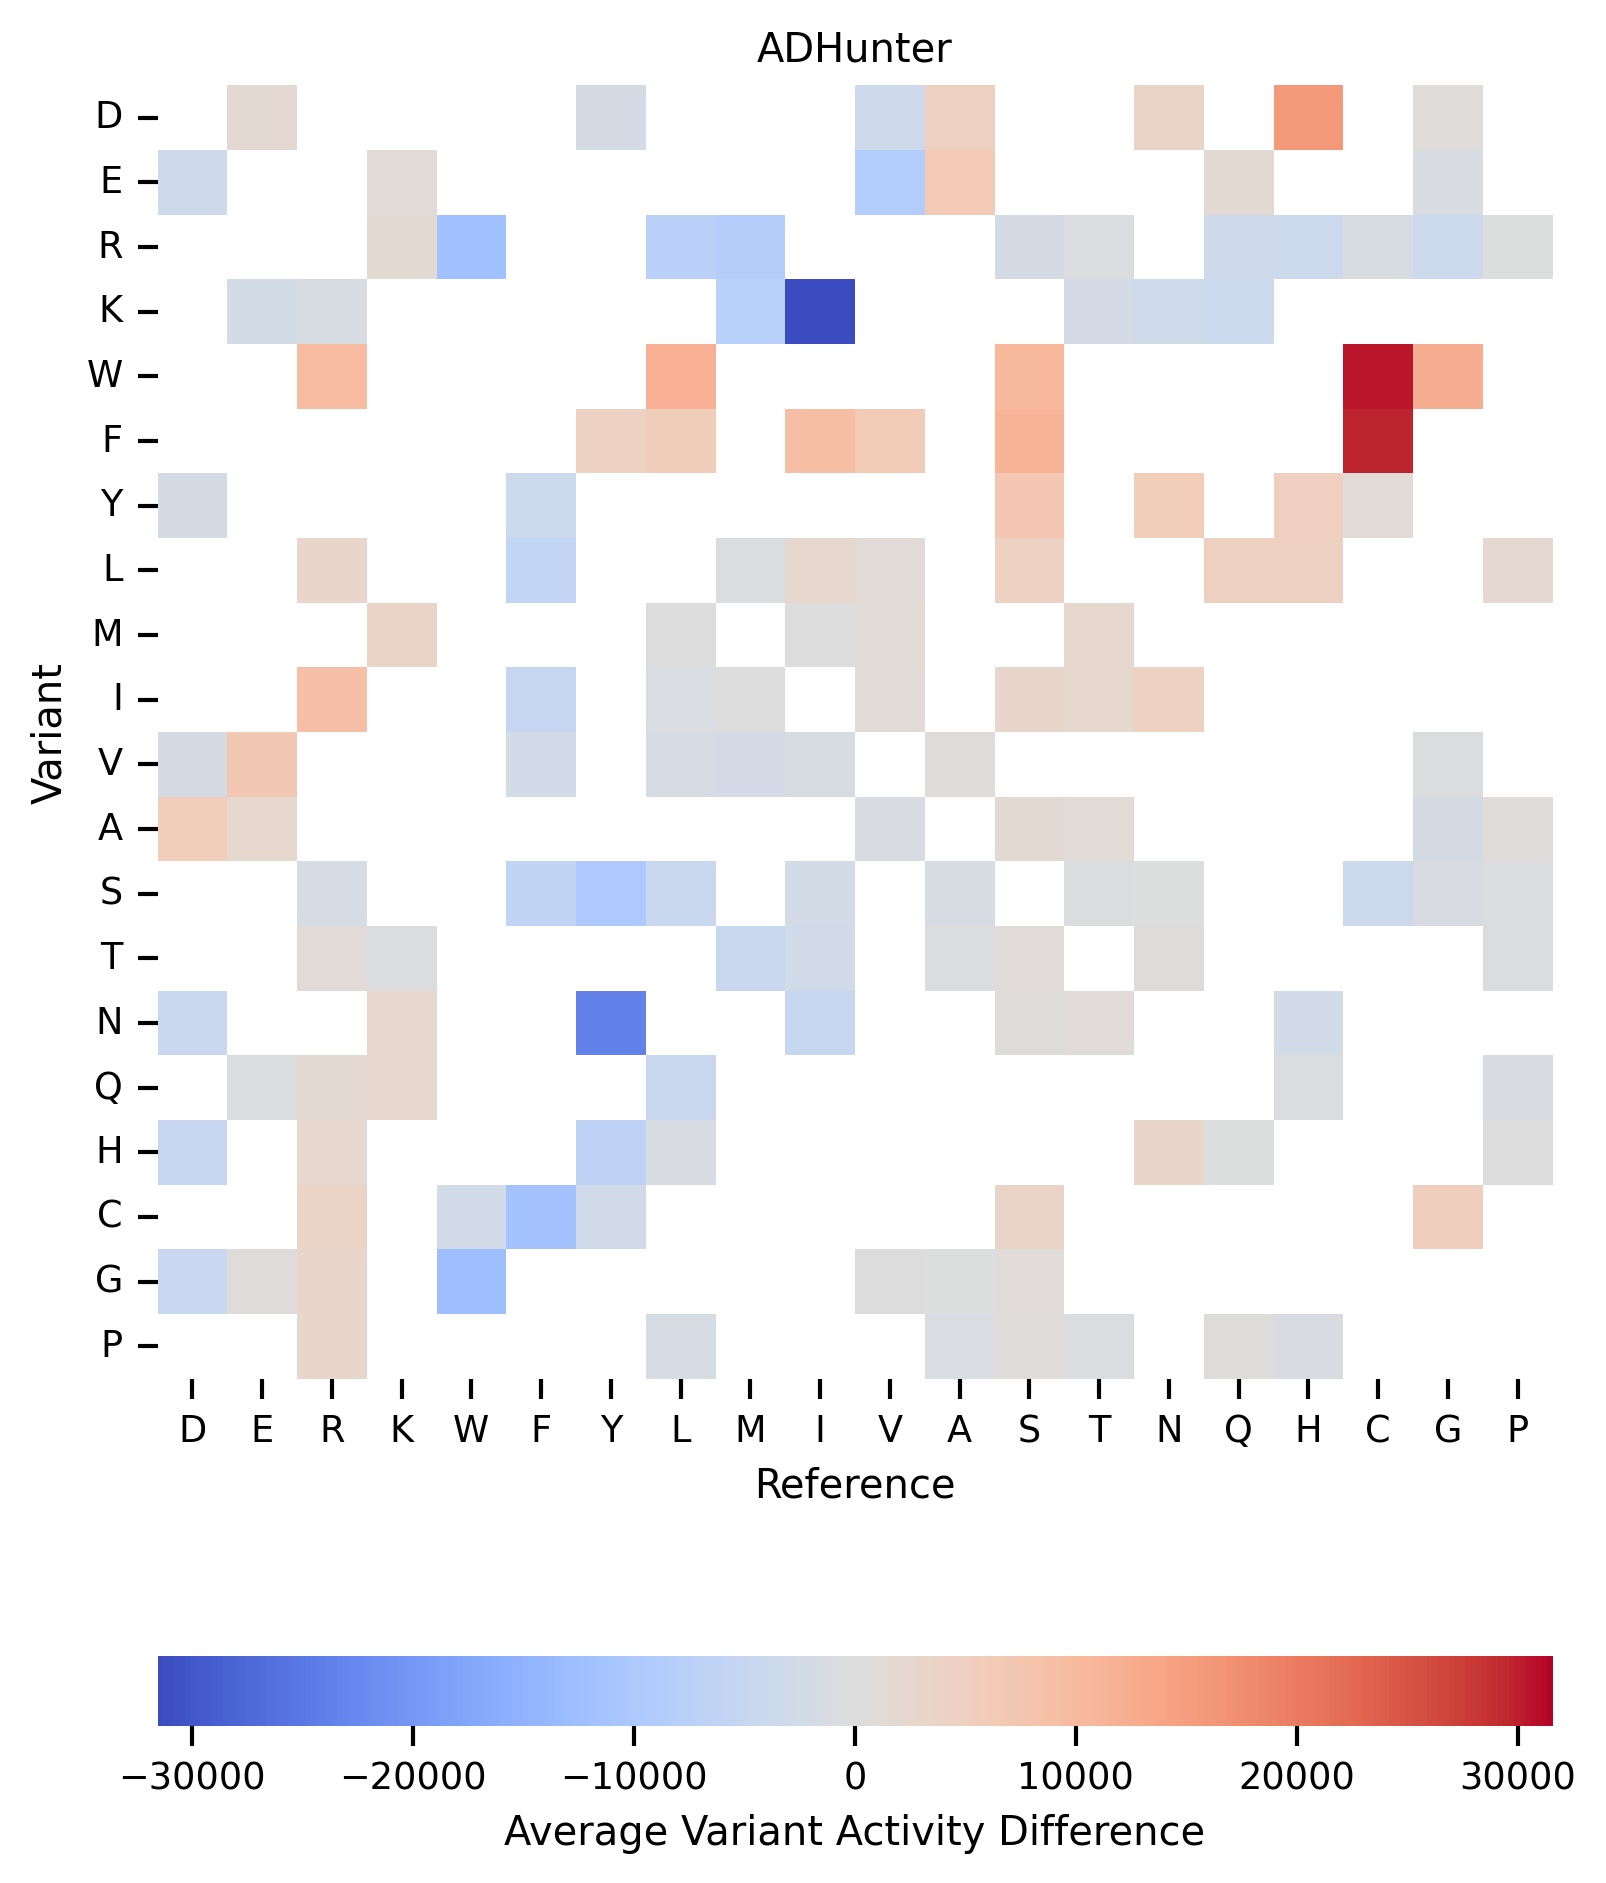

In [37]:
pivot_adhunter_results_summary_avg = pd.pivot(adhunter_results_summary_avg, values = "activ_diff_adhunter", index = "new_AA", columns = "orig_AA")
pivot_adhunter_results_summary_avg = pivot_adhunter_results_summary_avg.reindex(AA_order, axis = 0)
pivot_adhunter_results_summary_avg = pivot_adhunter_results_summary_avg.reindex(AA_order, axis = 1)
cmap_bound = max(abs(max(adhunter_results_summary_avg["activ_diff_adhunter"])),abs(min(adhunter_results_summary_avg["activ_diff_adhunter"])))

fig, ax = plt.subplots(figsize=(6, 8), dpi = 300)
sns.heatmap(pivot_adhunter_results_summary_avg, ax = ax, cmap = "coolwarm", vmin = -1 * cmap_bound, vmax = cmap_bound, cbar_kws = dict(location="bottom", label = "Average Variant Activity Difference"))
plt.yticks(rotation = 0)

plt.title("ADHunter");
plt.xlabel("Reference")
plt.ylabel("Variant");

# Building one summary table

In [38]:
adpred_with_var_pred

,GeneName,ProteinWindowSeq,position_wise_prob_adpred,Unnamed: 0.1,len,var_prot_pos,AD,AD_start,AD_end,var_AD_pos,var_pos_adpred_activity,ref_pos_adpred_activity,orig_AA,new_AA,activ_diff_adpred
1990,TET2_Q6N021_AD_1582-1751|g.105275270A>G(p.Asp1...,SSHTSGIYGSTSPMNFYSTSSQAAGSYLNSSNPMNPYPGLLNQNTQ...,"[0.00053041, 0.00165147, 0.00326038, 0.0034795...",-100000.0,170,1587,TET2_Q6N021_AD_1582-1751,1582,1751,5,0.004882,0.008462,D,G,-0.003580
1991,TET2_Q6N021_AD_1582-1751|g.105275276A>G(p.Tyr1...,SSHTSDICGSTSPMNFYSTSSQAAGSYLNSSNPMNPYPGLLNQNTQ...,"[0.00055169, 0.00173076, 0.00380862, 0.0042727...",-100000.0,170,1589,TET2_Q6N021_AD_1582-1751,1582,1751,7,0.006776,0.009306,Y,C,-0.002530
1992,TET2_Q6N021_AD_1582-1751|g.105275281A>T(p.Ser1...,SSHTSDIYGCTSPMNFYSTSSQAAGSYLNSSNPMNPYPGLLNQNTQ...,"[0.00144754, 0.00451254, 0.00941866, 0.0099359...",-100000.0,170,1591,TET2_Q6N021_AD_1582-1751,1582,1751,9,0.010985,0.006337,S,C,0.004648
1993,TET2_Q6N021_AD_1582-1751|g.105275293A>G(p.Met1...,SSHTSDIYGSTSPVNFYSTSSQAAGSYLNSSNPMNPYPGLLNQNTQ...,"[0.0006711, 0.00202642, 0.00400383, 0.00512687...",-100000.0,170,1595,TET2_Q6N021_AD_1582-1751,1582,1751,13,0.015106,0.018903,M,V,-0.003797
1994,TET2_Q6N021_AD_1582-1751|g.105275303A>G(p.Tyr1...,SSHTSDIYGSTSPMNFCSTSSQAAGSYLNSSNPMNPYPGLLNQNTQ...,"[0.000782, 0.00247028, 0.00422759, 0.00402325,...",-100000.0,170,1598,TET2_Q6N021_AD_1582-1751,1582,1751,16,0.016320,0.023387,Y,C,-0.007067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,CAMTA2_O94983_AD_285-468|g.4980411G>A(p.Pro304...,KAHTSPSSSSSSSSSGFAELLEIRPSPPTSRGGSSRGGTAILLLTG...,"[3.65740852e-05, 3.62961546e-05, 0.00010312100...",-100000.0,184,304,CAMTA2_O94983_AD_285-468,285,468,19,0.002118,0.000883,P,L,0.001236
1454,CAMTA2_O94983_AD_285-468|g.4980418C>A(p.Ala302...,KAHTSPSSSSSSSSSGFSEPLEIRPSPPTSRGGSSRGGTAILLLTG...,"[3.65740852e-05, 3.62961546e-05, 0.00010312100...",-100000.0,184,302,CAMTA2_O94983_AD_285-468,285,468,17,0.000678,0.000648,A,S,0.000030
1455,CAMTA2_O94983_AD_285-468|g.4980451A>G(p.Ser291...,KAHTSPPSSSSSSSSGFAEPLEIRPSPPTSRGGSSRGGTAILLLTG...,"[3.28503302e-05, 3.45399203e-05, 9.46332002e-0...",-100000.0,184,291,CAMTA2_O94983_AD_285-468,285,468,6,0.000284,0.000303,S,P,-0.000019
1456,CAMTA2_O94983_AD_285-468|g.4980453G>A(p.Pro290...,KAHTSLSSSSSSSSSGFAEPLEIRPSPPTSRGGSSRGGTAILLLTG...,"[7.84025178e-05, 7.78818721e-05, 0.00023476530...",-100000.0,184,290,CAMTA2_O94983_AD_285-468,285,468,5,0.000271,0.000136,P,L,0.000134


In [39]:
paddle_closest_tile

,var,var_pred,wt_pred,orig_AA,new_AA,activ_diff_paddle
0,TET2_Q6N021_AD_1582-1751|g.105275545T>C(p.Tyr1...,0.278393,0.257930,Y,H,0.020463
1,TET2_Q6N021_AD_1582-1751|g.105275735C>A(p.Pro1...,0.776625,0.967611,P,H,-0.190986
2,TET2_Q6N021_AD_1582-1751|g.105275599G>A(p.Gly1...,0.025680,0.134452,G,R,-0.108773
3,TET2_Q6N021_AD_1582-1751|g.105275677C>T(p.Pro1...,0.877722,0.967611,P,S,-0.089889
4,TET2_Q6N021_AD_1582-1751|g.105275350C>T(p.Pro1...,1.447820,1.383659,P,S,0.064161
...,...,...,...,...,...,...
62,CAMTA2_O94983_AD_285-468|g.4979929G>T(p.Pro465...,0.043928,0.078846,P,T,-0.034918
63,CAMTA2_O94983_AD_285-468|g.4980262T>C(p.Met354...,0.114723,0.157701,M,V,-0.042978
64,CAMTA2_O94983_AD_285-468|g.4980169G>C(p.Gln385...,0.950107,0.698398,Q,E,0.251709
65,CAMTA2_O94983_AD_285-468|g.4979953C>T(p.Gly457...,0.040427,0.078846,G,R,-0.038419


In [40]:
adhunter_closest_tile

,var,var_pred,wt_pred,orig_AA,new_AA,activ_diff_adhunter
0,TET2_Q6N021_AD_1582-1751|g.105275545T>C(p.Tyr1...,34170.109375,37560.636719,Y,H,-3390.527344
1,TET2_Q6N021_AD_1582-1751|g.105275735C>A(p.Pro1...,58852.671875,60707.257812,P,H,-1854.585938
2,TET2_Q6N021_AD_1582-1751|g.105275599G>A(p.Gly1...,58617.785156,61002.683594,G,R,-2384.898438
3,TET2_Q6N021_AD_1582-1751|g.105275677C>T(p.Pro1...,53091.054688,53002.324219,P,S,88.730469
4,TET2_Q6N021_AD_1582-1751|g.105275350C>T(p.Pro1...,56997.199219,60133.660156,P,S,-3136.460938
...,...,...,...,...,...,...
62,CAMTA2_O94983_AD_285-468|g.4979929G>T(p.Pro465...,34826.765625,31639.273438,P,T,3187.492188
63,CAMTA2_O94983_AD_285-468|g.4980262T>C(p.Met354...,20906.359375,22100.820312,M,V,-1194.460938
64,CAMTA2_O94983_AD_285-468|g.4980169G>C(p.Gln385...,27991.976562,28169.351562,Q,E,-177.375000
65,CAMTA2_O94983_AD_285-468|g.4979953C>T(p.Gly457...,28410.824219,31639.273438,G,R,-3228.449219


In [41]:
adhunter_paddle = pd.merge(paddle_closest_tile, adhunter_closest_tile, on = "var", suffixes = ('_paddle', '_adhunter'))
adhunter_paddle

,var,var_pred_paddle,wt_pred_paddle,orig_AA_paddle,new_AA_paddle,activ_diff_paddle,var_pred_adhunter,wt_pred_adhunter,orig_AA_adhunter,new_AA_adhunter,activ_diff_adhunter
0,TET2_Q6N021_AD_1582-1751|g.105275545T>C(p.Tyr1...,0.278393,0.257930,Y,H,0.020463,34170.109375,37560.636719,Y,H,-3390.527344
1,TET2_Q6N021_AD_1582-1751|g.105275735C>A(p.Pro1...,0.776625,0.967611,P,H,-0.190986,58852.671875,60707.257812,P,H,-1854.585938
2,TET2_Q6N021_AD_1582-1751|g.105275599G>A(p.Gly1...,0.025680,0.134452,G,R,-0.108773,58617.785156,61002.683594,G,R,-2384.898438
3,TET2_Q6N021_AD_1582-1751|g.105275677C>T(p.Pro1...,0.877722,0.967611,P,S,-0.089889,53091.054688,53002.324219,P,S,88.730469
4,TET2_Q6N021_AD_1582-1751|g.105275350C>T(p.Pro1...,1.447820,1.383659,P,S,0.064161,56997.199219,60133.660156,P,S,-3136.460938
...,...,...,...,...,...,...,...,...,...,...,...
3005,CAMTA2_O94983_AD_285-468|g.4979929G>T(p.Pro465...,0.043928,0.078846,P,T,-0.034918,34826.765625,31639.273438,P,T,3187.492188
3006,CAMTA2_O94983_AD_285-468|g.4980262T>C(p.Met354...,0.114723,0.157701,M,V,-0.042978,20906.359375,22100.820312,M,V,-1194.460938
3007,CAMTA2_O94983_AD_285-468|g.4980169G>C(p.Gln385...,0.950107,0.698398,Q,E,0.251709,27991.976562,28169.351562,Q,E,-177.375000
3008,CAMTA2_O94983_AD_285-468|g.4979953C>T(p.Gly457...,0.040427,0.078846,G,R,-0.038419,28410.824219,31639.273438,G,R,-3228.449219


In [42]:
summary = pd.merge(adhunter_paddle, adpred_with_var_pred, how = "left", left_on = "var", right_on = "GeneName", suffixes = ('', '_adpred'))
summary

,var,var_pred_paddle,wt_pred_paddle,orig_AA_paddle,new_AA_paddle,activ_diff_paddle,var_pred_adhunter,wt_pred_adhunter,orig_AA_adhunter,new_AA_adhunter,...,var_prot_pos,AD,AD_start,AD_end,var_AD_pos,var_pos_adpred_activity,ref_pos_adpred_activity,orig_AA,new_AA,activ_diff_adpred
0,TET2_Q6N021_AD_1582-1751|g.105275545T>C(p.Tyr1...,0.278393,0.257930,Y,H,0.020463,34170.109375,37560.636719,Y,H,...,1679,TET2_Q6N021_AD_1582-1751,1582,1751,97.0,0.002293,0.006433,Y,H,-0.004140
1,TET2_Q6N021_AD_1582-1751|g.105275735C>A(p.Pro1...,0.776625,0.967611,P,H,-0.190986,58852.671875,60707.257812,P,H,...,1742,TET2_Q6N021_AD_1582-1751,1582,1751,160.0,0.005125,0.005437,P,H,-0.000312
2,TET2_Q6N021_AD_1582-1751|g.105275599G>A(p.Gly1...,0.025680,0.134452,G,R,-0.108773,58617.785156,61002.683594,G,R,...,1697,TET2_Q6N021_AD_1582-1751,1582,1751,115.0,0.010076,0.022256,G,R,-0.012179
3,TET2_Q6N021_AD_1582-1751|g.105275677C>T(p.Pro1...,0.877722,0.967611,P,S,-0.089889,53091.054688,53002.324219,P,S,...,1723,TET2_Q6N021_AD_1582-1751,1582,1751,141.0,0.001927,0.001828,P,S,0.000099
4,TET2_Q6N021_AD_1582-1751|g.105275350C>T(p.Pro1...,1.447820,1.383659,P,S,0.064161,56997.199219,60133.660156,P,S,...,1614,TET2_Q6N021_AD_1582-1751,1582,1751,32.0,0.004715,0.004554,P,S,0.000160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3005,CAMTA2_O94983_AD_285-468|g.4979929G>T(p.Pro465...,0.043928,0.078846,P,T,-0.034918,34826.765625,31639.273438,P,T,...,465,CAMTA2_O94983_AD_285-468,285,468,180.0,0.000160,0.000153,P,T,0.000007
3006,CAMTA2_O94983_AD_285-468|g.4980262T>C(p.Met354...,0.114723,0.157701,M,V,-0.042978,20906.359375,22100.820312,M,V,...,354,CAMTA2_O94983_AD_285-468,285,468,69.0,0.000325,0.000405,M,V,-0.000080
3007,CAMTA2_O94983_AD_285-468|g.4980169G>C(p.Gln385...,0.950107,0.698398,Q,E,0.251709,27991.976562,28169.351562,Q,E,...,385,CAMTA2_O94983_AD_285-468,285,468,100.0,0.004758,0.002712,Q,E,0.002046
3008,CAMTA2_O94983_AD_285-468|g.4979953C>T(p.Gly457...,0.040427,0.078846,G,R,-0.038419,28410.824219,31639.273438,G,R,...,457,CAMTA2_O94983_AD_285-468,285,468,172.0,0.002241,0.004395,G,R,-0.002154


In [43]:
summary.columns

Index(['var', 'var_pred_paddle', 'wt_pred_paddle', 'orig_AA_paddle',
       'new_AA_paddle', 'activ_diff_paddle', 'var_pred_adhunter',
       'wt_pred_adhunter', 'orig_AA_adhunter', 'new_AA_adhunter',
       'activ_diff_adhunter', 'GeneName', 'ProteinWindowSeq',
       'position_wise_prob_adpred', 'Unnamed: 0.1', 'len', 'var_prot_pos',
       'AD', 'AD_start', 'AD_end', 'var_AD_pos', 'var_pos_adpred_activity',
       'ref_pos_adpred_activity', 'orig_AA', 'new_AA', 'activ_diff_adpred'],
      dtype='object')

In [44]:
summary = summary[['var', 'var_pred_paddle', 'wt_pred_paddle', 'activ_diff_paddle', 
                   'var_pred_adhunter', 'wt_pred_adhunter', 'activ_diff_adhunter', 'orig_AA_adhunter', 'new_AA_adhunter',
                   'var_pos_adpred_activity','ref_pos_adpred_activity', 'activ_diff_adpred']]
summary

,var,var_pred_paddle,wt_pred_paddle,activ_diff_paddle,var_pred_adhunter,wt_pred_adhunter,activ_diff_adhunter,orig_AA_adhunter,new_AA_adhunter,var_pos_adpred_activity,ref_pos_adpred_activity,activ_diff_adpred
0,TET2_Q6N021_AD_1582-1751|g.105275545T>C(p.Tyr1...,0.278393,0.257930,0.020463,34170.109375,37560.636719,-3390.527344,Y,H,0.002293,0.006433,-0.004140
1,TET2_Q6N021_AD_1582-1751|g.105275735C>A(p.Pro1...,0.776625,0.967611,-0.190986,58852.671875,60707.257812,-1854.585938,P,H,0.005125,0.005437,-0.000312
2,TET2_Q6N021_AD_1582-1751|g.105275599G>A(p.Gly1...,0.025680,0.134452,-0.108773,58617.785156,61002.683594,-2384.898438,G,R,0.010076,0.022256,-0.012179
3,TET2_Q6N021_AD_1582-1751|g.105275677C>T(p.Pro1...,0.877722,0.967611,-0.089889,53091.054688,53002.324219,88.730469,P,S,0.001927,0.001828,0.000099
4,TET2_Q6N021_AD_1582-1751|g.105275350C>T(p.Pro1...,1.447820,1.383659,0.064161,56997.199219,60133.660156,-3136.460938,P,S,0.004715,0.004554,0.000160
...,...,...,...,...,...,...,...,...,...,...,...,...
3005,CAMTA2_O94983_AD_285-468|g.4979929G>T(p.Pro465...,0.043928,0.078846,-0.034918,34826.765625,31639.273438,3187.492188,P,T,0.000160,0.000153,0.000007
3006,CAMTA2_O94983_AD_285-468|g.4980262T>C(p.Met354...,0.114723,0.157701,-0.042978,20906.359375,22100.820312,-1194.460938,M,V,0.000325,0.000405,-0.000080
3007,CAMTA2_O94983_AD_285-468|g.4980169G>C(p.Gln385...,0.950107,0.698398,0.251709,27991.976562,28169.351562,-177.375000,Q,E,0.004758,0.002712,0.002046
3008,CAMTA2_O94983_AD_285-468|g.4979953C>T(p.Gly457...,0.040427,0.078846,-0.038419,28410.824219,31639.273438,-3228.449219,G,R,0.002241,0.004395,-0.002154


In [45]:
from scipy.stats import spearmanr

def plot_two(x, y, adpred_input = False): 
    x = "activ_diff_" + x
    y = "activ_diff_" + y
    plt.scatter(data = summary, x = x, y = y, s = 0.25, alpha = 0.5)
    plt.xlabel(x)
    plt.ylabel(y)

    if adpred_input:
        r, p = spearmanr(summary.dropna()[x], summary.dropna()[y])
        print(r)
    else:
        r, p = spearmanr(summary[x], summary[y])
        print(r)

0.328102472666563


Text(0, 0.5, 'ADHunter')

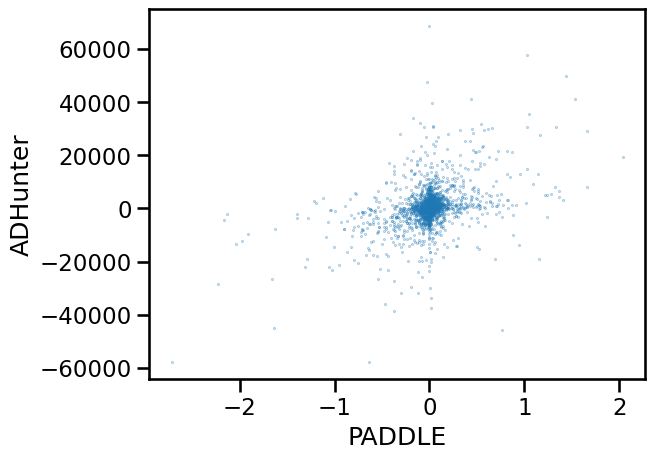

In [46]:
sns.set_context('talk')
plot_two(x = "paddle", y = "adhunter")
plt.xlabel("PADDLE")
plt.ylabel("ADHunter")

0.5179602482524014


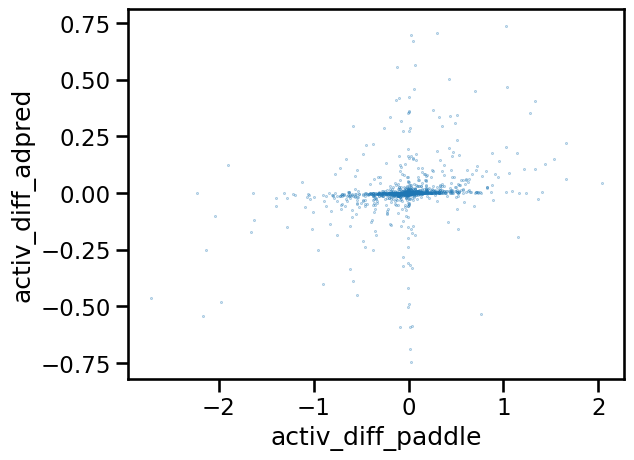

In [47]:
plot_two(x = "paddle", y = "adpred", adpred_input = True)

0.4603693294839481


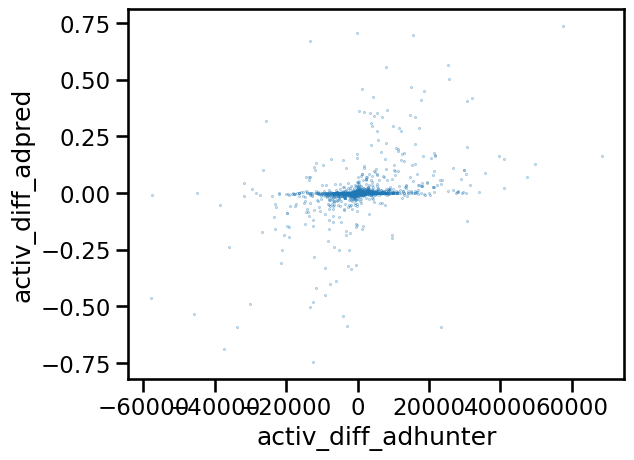

In [48]:
plot_two(x = "adhunter", y = "adpred", adpred_input = True)

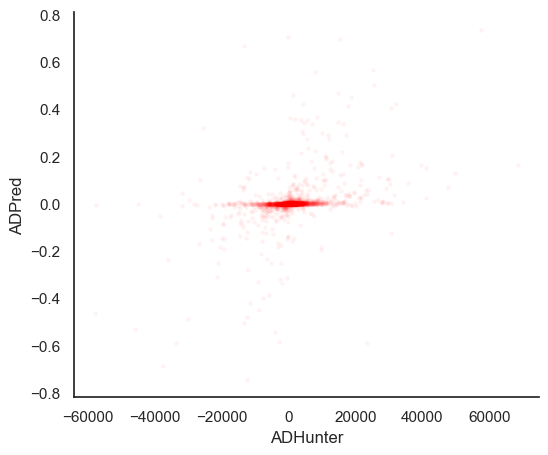

In [49]:
sns.set_theme(rc={'figure.figsize':(6,5)}, style = "white")
g = sns.scatterplot(x = "activ_diff_adhunter", y = "activ_diff_adpred", 
            data = summary.sort_values("activ_diff_paddle"), alpha = 0.05, 
           s = 10, color = "red", linewidth = 0)
plt.xlabel("ADHunter")
plt.ylabel("ADPred")

sns.despine()
#fig.colorbar(g, label = "PADDLE")

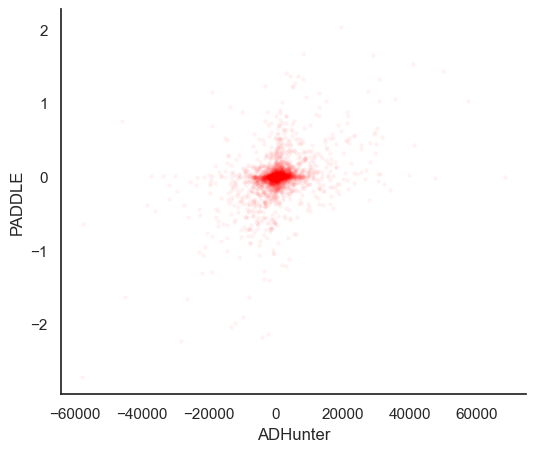

In [50]:
sns.set_theme(rc={'figure.figsize':(6,5)}, style = "white")
sns.set_style("white")
g = sns.scatterplot(x = "activ_diff_adhunter", y = "activ_diff_paddle", 
            data = summary.sort_values("activ_diff_adpred"), alpha = 0.05, 
           s = 10, palette  = "flare", linewidth = 0, color = "red")
plt.xlabel("ADHunter")
plt.ylabel("PADDLE")

sns.despine()
#fig.colorbar(g, label = "PADDLE")

Text(0, 0.5, 'ADPred')

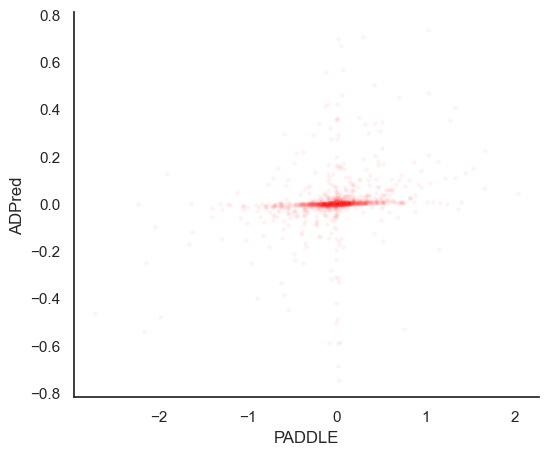

In [51]:
sns.set_theme(rc={'figure.figsize':(6,5)}, style = "white")
sns.set_style("white")

g = sns.scatterplot(x = "activ_diff_paddle", y = "activ_diff_adpred", 
                    data = summary.sort_values("activ_diff_adhunter"), alpha = 0.05, 
           s = 10, color = "red")

sns.despine()
plt.xlabel("PADDLE")
plt.ylabel("ADPred")
#fig.colorbar(g, label = "PADDLE")

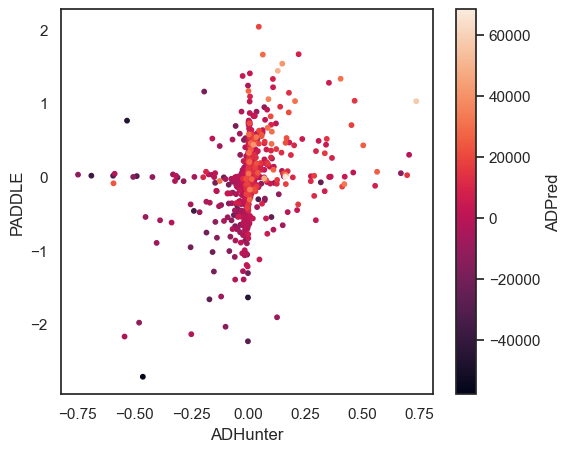

In [52]:
sns.set_theme(rc={'figure.figsize':(6,5)}, style = "white")
g = plt.scatter("activ_diff_adpred", "activ_diff_paddle", c='activ_diff_adhunter',
            data = summary.sort_values("activ_diff_adhunter"), alpha = 1,
           s = 10)
plt.xlabel("ADHunter")
plt.ylabel("PADDLE")
fig.colorbar(g, label = "ADPred")


In [55]:
summary

,var,var_pred_paddle,wt_pred_paddle,activ_diff_paddle,var_pred_adhunter,wt_pred_adhunter,activ_diff_adhunter,orig_AA_adhunter,new_AA_adhunter,var_pos_adpred_activity,ref_pos_adpred_activity,activ_diff_adpred,uniprot_id,POS
0,TET2_Q6N021_AD_1582-1751|g.105275545T>C(p.Tyr1...,0.278393,0.257930,0.020463,34170.109375,37560.636719,-3390.527344,Y,H,0.002293,0.006433,-0.004140,Q6N021,105275545
1,TET2_Q6N021_AD_1582-1751|g.105275735C>A(p.Pro1...,0.776625,0.967611,-0.190986,58852.671875,60707.257812,-1854.585938,P,H,0.005125,0.005437,-0.000312,Q6N021,105275735
2,TET2_Q6N021_AD_1582-1751|g.105275599G>A(p.Gly1...,0.025680,0.134452,-0.108773,58617.785156,61002.683594,-2384.898438,G,R,0.010076,0.022256,-0.012179,Q6N021,105275599
3,TET2_Q6N021_AD_1582-1751|g.105275677C>T(p.Pro1...,0.877722,0.967611,-0.089889,53091.054688,53002.324219,88.730469,P,S,0.001927,0.001828,0.000099,Q6N021,105275677
4,TET2_Q6N021_AD_1582-1751|g.105275350C>T(p.Pro1...,1.447820,1.383659,0.064161,56997.199219,60133.660156,-3136.460938,P,S,0.004715,0.004554,0.000160,Q6N021,105275350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3005,CAMTA2_O94983_AD_285-468|g.4979929G>T(p.Pro465...,0.043928,0.078846,-0.034918,34826.765625,31639.273438,3187.492188,P,T,0.000160,0.000153,0.000007,O94983,4979929
3006,CAMTA2_O94983_AD_285-468|g.4980262T>C(p.Met354...,0.114723,0.157701,-0.042978,20906.359375,22100.820312,-1194.460938,M,V,0.000325,0.000405,-0.000080,O94983,4980262
3007,CAMTA2_O94983_AD_285-468|g.4980169G>C(p.Gln385...,0.950107,0.698398,0.251709,27991.976562,28169.351562,-177.375000,Q,E,0.004758,0.002712,0.002046,O94983,4980169
3008,CAMTA2_O94983_AD_285-468|g.4979953C>T(p.Gly457...,0.040427,0.078846,-0.038419,28410.824219,31639.273438,-3228.449219,G,R,0.002241,0.004395,-0.002154,O94983,4979953


In [89]:
cols = ["activ_diff_paddle", "activ_diff_adpred", "activ_diff_adhunter"]

summary_for_pairplot = summary[cols]
for col in cols:
    summary_for_pairplot[col] = (summary_for_pairplot[col] - np.mean(summary_for_pairplot[col])) / np.std(summary_for_pairplot[col])

summary_for_pairplot

,activ_diff_paddle,activ_diff_adpred,activ_diff_adhunter
0,0.101484,-0.088642,-0.564848
1,-0.696070,-0.035332,-0.336022
2,-0.385975,-0.200616,-0.415028
3,-0.314747,-0.029602,-0.046504
4,0.266305,-0.028747,-0.526997
...,...,...,...
3005,-0.107407,-0.030883,0.415152
3006,-0.137807,-0.032092,-0.237676
3007,0.973706,-0.002484,-0.086149
3008,-0.120612,-0.060975,-0.540701


<Axes: xlabel='activ_diff_paddle', ylabel='Density'>

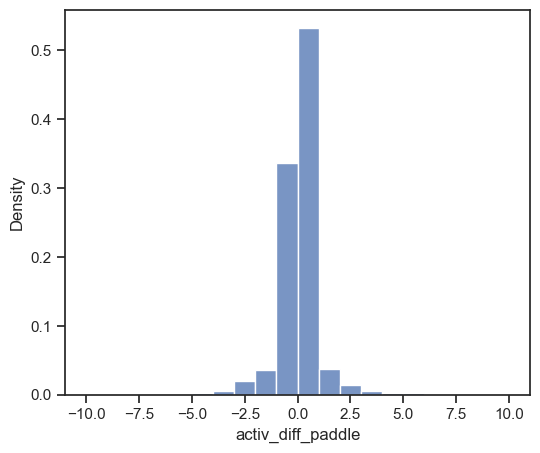

In [90]:
sns.histplot(summary_for_pairplot["activ_diff_paddle"], 
             stat = "density", 
             bins = np.arange(-10, 11, 1))

<Axes: xlabel='activ_diff_adpred', ylabel='Density'>

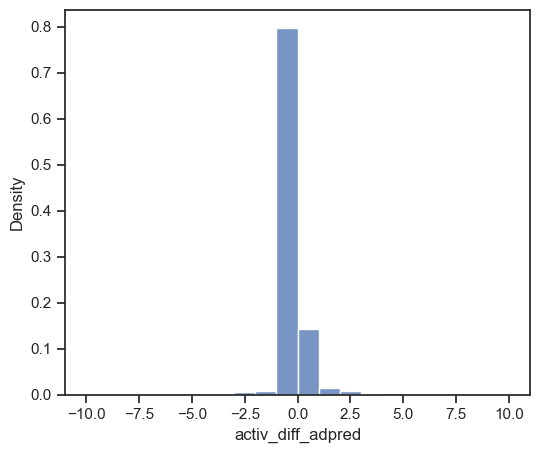

In [91]:
sns.histplot(summary_for_pairplot["activ_diff_adpred"], 
             stat = "density", 
             bins = np.arange(-10, 11, 1))

<Axes: ylabel='Count'>

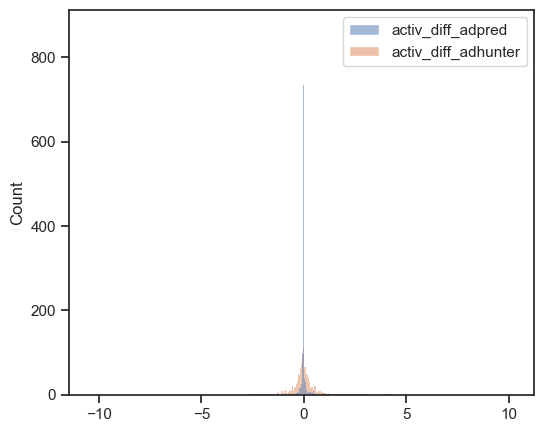

In [92]:
sns.histplot(summary_for_pairplot[["activ_diff_adpred", "activ_diff_adhunter"]])

<Axes: xlabel='ADPred', ylabel='ADHunter'>

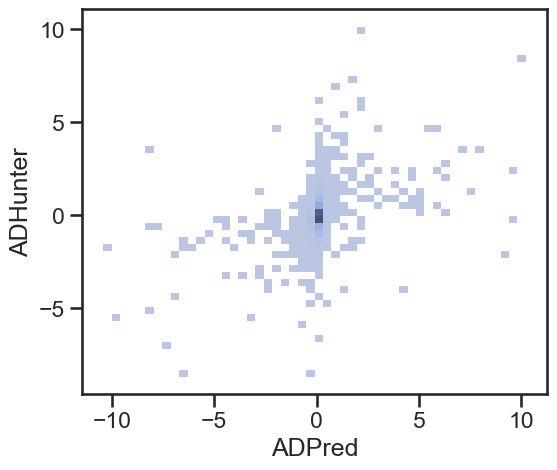

In [235]:
sns.histplot(data=summary_for_pairplot, x="ADPred", y="ADHunter", stat="density", bins=50)

In [262]:
summary_for_pairplot

,PADDLE,ADPred,ADHunter
0,0.101484,-0.088642,-0.564848
1,-0.696070,-0.035332,-0.336022
2,-0.385975,-0.200616,-0.415028
3,-0.314747,-0.029602,-0.046504
4,0.266305,-0.028747,-0.526997
...,...,...,...
3005,-0.107407,-0.030883,0.415152
3006,-0.137807,-0.032092,-0.237676
3007,0.973706,-0.002484,-0.086149
3008,-0.120612,-0.060975,-0.540701


<Figure size 1800x1500 with 0 Axes>

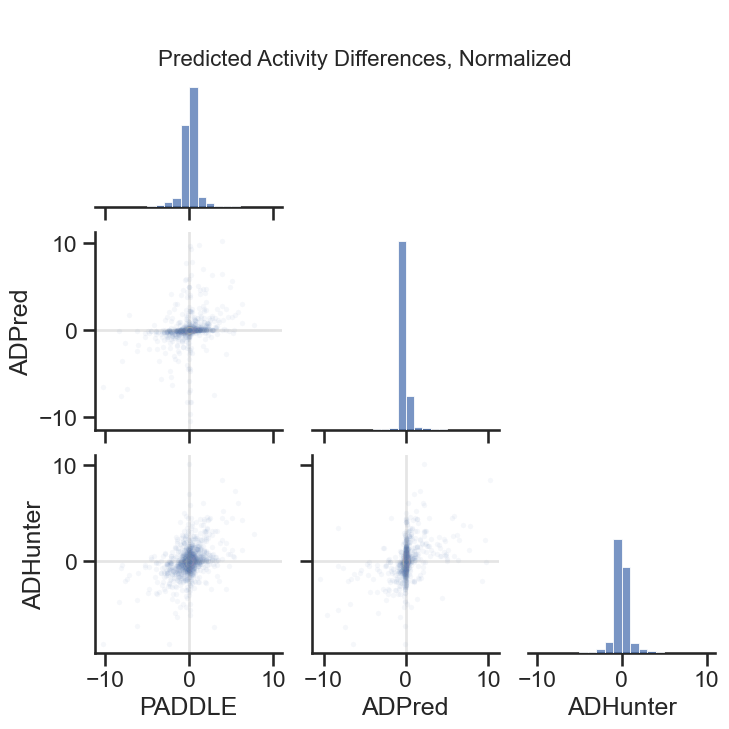

In [244]:
sns.set_theme(style = 'ticks')
sns.set_context('talk')
plt.figure(dpi = 300)

summary_for_pairplot = summary_for_pairplot.rename(columns = {"activ_diff_adpred" : "ADPred",
                                                              "activ_diff_adhunter" : "ADHunter",
                                                              "activ_diff_paddle" : "PADDLE"})
g = sns.pairplot(data=summary_for_pairplot, 
                 plot_kws=dict(s = 15, alpha = 0.05),
             diag_kws=dict(bins=np.arange(-10, 11, 1), stat = "density"),
             corner = True);

for i in range(len(g.axes)):
    for j in range(len(g.axes[i])):
        ax = g.axes[i, j]
        if ax is not None:
            # Only add lines to the lower triangle scatter plots (i.e., exclude histograms on the diagonal)
            if i > j:  # This condition ensures we are looking at the lower triangle (scatter plots)
                ax.axhline(0, color='gray', linewidth=2, alpha = 0.2)  # y = 0 line
                ax.axvline(0, color='gray', linewidth=2, alpha = 0.2)  # x = 0 line
                
                xlim = ax.get_xlim()
                ylim = ax.get_ylim()

                
plt.suptitle("Predicted Activity Differences, Normalized", fontsize=16, y = 0.92);


In [156]:
summary_for_pairplot = summary_for_pairplot.dropna()
summary_for_pairplot

,PADDLE,ADPred,ADHunter
0,0.101484,-0.088642,-0.564848
1,-0.696070,-0.035332,-0.336022
2,-0.385975,-0.200616,-0.415028
3,-0.314747,-0.029602,-0.046504
4,0.266305,-0.028747,-0.526997
...,...,...,...
3005,-0.107407,-0.030883,0.415152
3006,-0.137807,-0.032092,-0.237676
3007,0.973706,-0.002484,-0.086149
3008,-0.120612,-0.060975,-0.540701


Text(0.5, 1.01, 'Normalized Activity Differences')

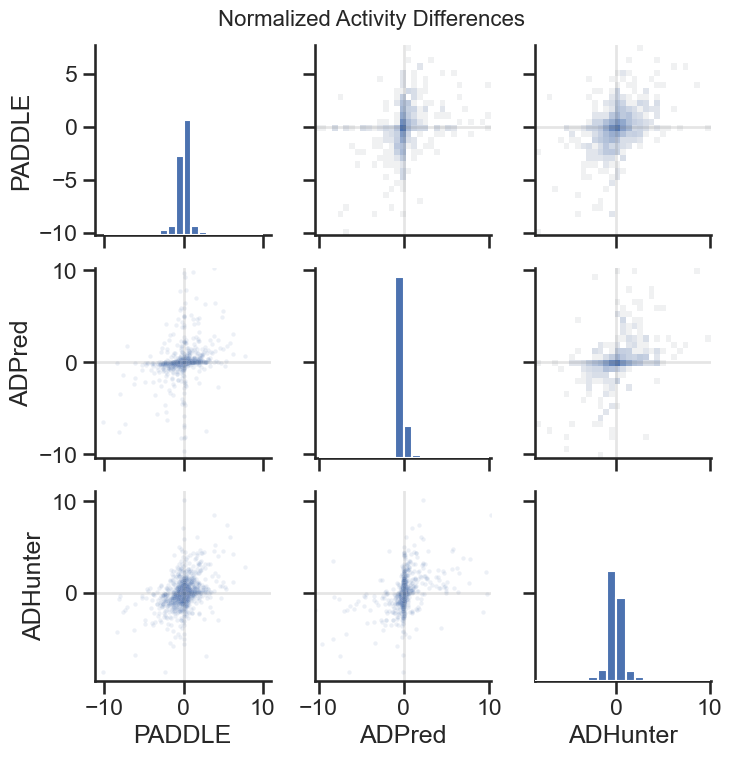

In [261]:
from matplotlib.colors import LogNorm

g = sns.PairGrid(summary_for_pairplot)
g.map_diag(plt.hist, bins=np.arange(-10, 11, 1))

def pairgrid_heatmap(x, y, **kws):
    cmap = sns.light_palette(kws.pop("color"), as_cmap=True)
    plt.hist2d(x, y, cmap=cmap, cmin=1, **kws)


g.map_lower(sns.scatterplot, s = 10, alpha = 0.1)
g.map_upper(pairgrid_heatmap, bins=31, norm=LogNorm())

for i in range(len(g.axes)):
    for j in range(len(g.axes[i])):
        ax = g.axes[i, j]
        if ax is not None:
            # Only add lines to the lower triangle scatter plots (i.e., exclude histograms on the diagonal)
            if i != j:  # This condition ensures we are looking at the lower triangle (scatter plots)
                ax.axhline(0, color='gray', linewidth=2, alpha = 0.2)  # y = 0 line
                ax.axvline(0, color='gray', linewidth=2, alpha = 0.2)  # x = 0 line
                
                xlim = ax.get_xlim()
                ylim = ax.get_ylim()
                # ax.plot([min(xlim[0], ylim[0]), max(xlim[1], ylim[1])], 
                #                 [min(xlim[0], ylim[0]), max(xlim[1], ylim[1])], 
                #                  linewidth=2, alpha = 0.2, color = "gray")
                

plt.suptitle("Normalized Activity Differences", fontsize=16, y = 1.01)


<Figure size 1800x1500 with 0 Axes>

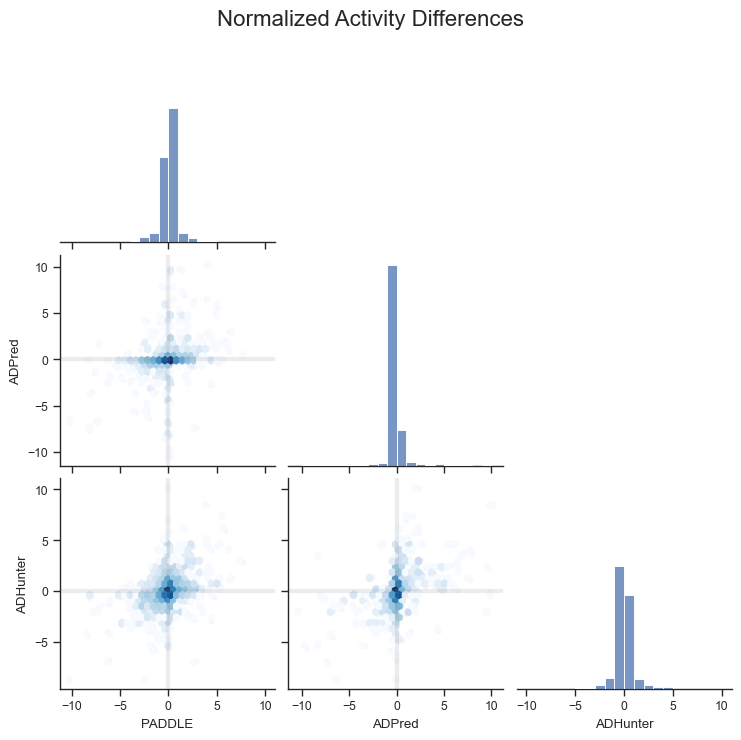

In [148]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set seaborn theme and context
sns.set_theme(style='ticks')
sns.set_context('paper')
plt.figure(dpi=300)

# Rename columns for better readability
summary_for_pairplot = summary_for_pairplot.rename(columns={"activ_diff_adpred": "ADPred",
                                                           "activ_diff_adhunter": "ADHunter",
                                                           "activ_diff_paddle": "PADDLE"})

# Create the pairplot
g = sns.pairplot(data=summary_for_pairplot, 
                 kind='scatter',  # We will manually replace this with hexbin
                 plot_kws=dict(s=20, alpha=0.05),
                 diag_kws=dict(bins=np.arange(-10, 11, 1), stat="density"),
                 corner=True)

# Initialize variables to store the minimum and maximum values of hexbin counts
vmin, vmax = np.inf, -np.inf

# First loop to determine the global vmin and vmax for the color scale
for i in range(len(g.axes)):
    for j in range(len(g.axes[i])):
        ax = g.axes[i, j]
        if ax is not None:
            # Only replace scatter plots with hexbin in the lower triangle
            if i > j:  # Lower triangle (scatter plots)
                x = summary_for_pairplot.iloc[:, j]
                y = summary_for_pairplot.iloc[:, i]
                
                # Create hexbin plot and determine the min and max count for color scale
                hb = ax.hexbin(x, y, gridsize=30, cmap='Blues', mincnt=1, bins='log')
                
                # Update the global min and max values for color scaling
                vmin = min(vmin, hb.get_array().min())
                vmax = max(vmax, hb.get_array().max())
                # Add the y = 0 and x = 0 lines
                ax.axhline(0, color='gray', linewidth=3, alpha=0.15)  # y = 0 line
                ax.axvline(0, color='gray', linewidth=3, alpha=0.15)  # x = 0 line

# # Second loop to plot hexbin plots with the same color scale (vmin, vmax) and add the color bar
# for i in range(len(g.axes)):
#     for j in range(len(g.axes[i])):
#         ax = g.axes[i, j]
#         if ax is not None:
#             # Only replace scatter plots with hexbin in the lower triangle
#             if i > j:  # Lower triangle (scatter plots)
#                 x = summary_for_pairplot.iloc[:, j]
#                 y = summary_for_pairplot.iloc[:, i]
                
#                 # Create hexbin plot with the same color scale across all subplots
#                 hb = ax.hexbin(x, y, gridsize=10, cmap='Blues', mincnt=1, bins='log', vmin=vmin, vmax=vmax)
                
#                 # Add the y = 0 and x = 0 lines
#                 ax.axhline(0, color='gray', linewidth=2, alpha=0.2)  # y = 0 line
#                 ax.axvline(0, color='gray', linewidth=2, alpha=0.2)  # x = 0 line

# Add a colorbar with the same scale for all hexbin plots
#cb = g.fig.colorbar(hb, ax=g.axes.flatten().tolist(), orientation='vertical')
#cb.set_label('Log Count')  # Label for the color bar

# Add a title to the plot
plt.suptitle("Normalized Activity Differences", fontsize=16)

# Adjust the title position to avoid overlap
plt.subplots_adjust(top=0.95)  # Reduce the space at the top to make room for the title

# Show the plot
plt.show()


--- 
How do activity differences compare to AM pathogenicity?

In [53]:
summary["uniprot_id"] = summary["var"].str.split("_").str[1]
summary["POS"] = summary["var"].str.extract(r'g.(\d+).>').astype(int)
summary

,var,var_pred_paddle,wt_pred_paddle,activ_diff_paddle,var_pred_adhunter,wt_pred_adhunter,activ_diff_adhunter,orig_AA_adhunter,new_AA_adhunter,var_pos_adpred_activity,ref_pos_adpred_activity,activ_diff_adpred,uniprot_id,POS
0,TET2_Q6N021_AD_1582-1751|g.105275545T>C(p.Tyr1...,0.278393,0.257930,0.020463,34170.109375,37560.636719,-3390.527344,Y,H,0.002293,0.006433,-0.004140,Q6N021,105275545
1,TET2_Q6N021_AD_1582-1751|g.105275735C>A(p.Pro1...,0.776625,0.967611,-0.190986,58852.671875,60707.257812,-1854.585938,P,H,0.005125,0.005437,-0.000312,Q6N021,105275735
2,TET2_Q6N021_AD_1582-1751|g.105275599G>A(p.Gly1...,0.025680,0.134452,-0.108773,58617.785156,61002.683594,-2384.898438,G,R,0.010076,0.022256,-0.012179,Q6N021,105275599
3,TET2_Q6N021_AD_1582-1751|g.105275677C>T(p.Pro1...,0.877722,0.967611,-0.089889,53091.054688,53002.324219,88.730469,P,S,0.001927,0.001828,0.000099,Q6N021,105275677
4,TET2_Q6N021_AD_1582-1751|g.105275350C>T(p.Pro1...,1.447820,1.383659,0.064161,56997.199219,60133.660156,-3136.460938,P,S,0.004715,0.004554,0.000160,Q6N021,105275350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3005,CAMTA2_O94983_AD_285-468|g.4979929G>T(p.Pro465...,0.043928,0.078846,-0.034918,34826.765625,31639.273438,3187.492188,P,T,0.000160,0.000153,0.000007,O94983,4979929
3006,CAMTA2_O94983_AD_285-468|g.4980262T>C(p.Met354...,0.114723,0.157701,-0.042978,20906.359375,22100.820312,-1194.460938,M,V,0.000325,0.000405,-0.000080,O94983,4980262
3007,CAMTA2_O94983_AD_285-468|g.4980169G>C(p.Gln385...,0.950107,0.698398,0.251709,27991.976562,28169.351562,-177.375000,Q,E,0.004758,0.002712,0.002046,O94983,4980169
3008,CAMTA2_O94983_AD_285-468|g.4979953C>T(p.Gly457...,0.040427,0.078846,-0.038419,28410.824219,31639.273438,-3228.449219,G,R,0.002241,0.004395,-0.002154,O94983,4979953


In [54]:
am = pd.read_csv("../output/alphamissense_path_preds_AD_vars.csv", index_col = 0)
am

,#CHROM,1,POS,3,4,5,6,7,8,9,...,20,21,22,genome,uniprot_id,transcript_id,protein_variant,am_pathogenicity,am_class,ENST
0,chr22,42214325,42214326,AD,ENSG00000100207,.,-,ENST00000359486,22,42214325,...,H,R,No-Syn,hg38,Q9UGU0,ENST00000359486.7,H327R,0.2956,likely_benign,ENST00000359486
1,chr22,42214327,42214328,AD,ENSG00000100207,.,-,ENST00000359486,22,42214327,...,Q,H,No-Syn,hg38,Q9UGU0,ENST00000359486.7,Q326H,0.2083,likely_benign,ENST00000359486
2,chr22,42214329,42214330,AD,ENSG00000100207,.,-,ENST00000359486,22,42214329,...,Q,E,No-Syn,hg38,Q9UGU0,ENST00000359486.7,Q326E,0.1679,likely_benign,ENST00000359486
3,chr22,42214335,42214336,AD,ENSG00000100207,.,-,ENST00000359486,22,42214335,...,P,S,No-Syn,hg38,Q9UGU0,ENST00000359486.7,P324S,0.0586,likely_benign,ENST00000359486
4,chr22,42214352,42214353,AD,ENSG00000100207,.,-,ENST00000359486,22,42214352,...,P,L,No-Syn,hg38,Q9UGU0,ENST00000359486.7,P318L,0.1107,likely_benign,ENST00000359486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3175,chr17,40076878,40076879,AD,ENSG00000126351,.,+,ENST00000264637,17,40076878,...,S,L,No-Syn,hg38,P10827,ENST00000264637.8,S21L,0.0703,likely_benign,ENST00000264637
3176,chr17,40076893,40076894,AD,ENSG00000126351,.,+,ENST00000264637,17,40076893,...,R,Q,No-Syn,hg38,P10827,ENST00000264637.8,R26Q,0.2129,likely_benign,ENST00000264637
3177,chr17,40076899,40076900,AD,ENSG00000126351,.,+,ENST00000264637,17,40076899,...,R,K,No-Syn,hg38,P10827,ENST00000264637.8,R28K,0.1445,likely_benign,ENST00000264637
3178,chr17,40076910,40076911,AD,ENSG00000126351,.,+,ENST00000264637,17,40076910,...,Q,E,No-Syn,hg38,P10827,ENST00000264637.8,Q32E,0.1266,likely_benign,ENST00000264637


In [231]:
summary_with_am = pd.merge(summary, am, 
         how = "left", 
         left_on = ["POS", "uniprot_id", "orig_AA_adhunter", "new_AA_adhunter"],
         right_on = ["POS", "uniprot_id", '20', '21'],
)
summary_with_am = summary_with_am.drop_duplicates(["var", "activ_diff_paddle", "activ_diff_adhunter", "activ_diff_adpred", "am_pathogenicity"])
summary_with_am

,var,var_pred_paddle,wt_pred_paddle,activ_diff_paddle,var_pred_adhunter,wt_pred_adhunter,activ_diff_adhunter,orig_AA_adhunter,new_AA_adhunter,var_pos_adpred_activity,...,19,20,21,22,genome,transcript_id,protein_variant,am_pathogenicity,am_class,ENST
0,SRCAP_Q6ZRS2_AD_198-1445|g.30710822A>T(p.Glu40...,0.147968,0.129918,0.018050,24071.039062,23811.289062,259.750000,E,D,NaN,...,0.000009,E,D,No-Syn,hg38,ENST00000262518.9,E401D,0.1233,likely_benign,ENST00000262518
1,SRCAP_Q6ZRS2_AD_198-1445|g.30721233C>T(p.Pro11...,-0.181365,-0.175508,-0.005857,42768.371094,43681.906250,-913.535156,P,S,NaN,...,0.000033,P,S,No-Syn,hg38,ENST00000262518.9,P1100S,0.0882,likely_benign,ENST00000262518
2,SRCAP_Q6ZRS2_AD_198-1445|g.30721455G>A(p.Asp11...,-0.179097,-0.125538,-0.053559,46607.949219,48048.144531,-1440.195312,D,N,NaN,...,0.000028,D,N,No-Syn,hg38,ENST00000262518.9,D1174N,0.4414,ambiguous,ENST00000262518
3,SRCAP_Q6ZRS2_AD_198-1445|g.30723605C>T(p.Pro13...,-0.034244,-0.022734,-0.011510,29713.363281,32487.164062,-2773.800781,P,L,NaN,...,0.000009,P,L,No-Syn,hg38,ENST00000262518.9,P1394L,0.1763,likely_benign,ENST00000262518
4,SRCAP_Q6ZRS2_AD_198-1445|g.30720897C>A(p.Pro10...,-0.132803,-0.136810,0.004007,38172.605469,38496.671875,-324.066406,P,T,NaN,...,0.000019,P,T,No-Syn,hg38,ENST00000262518.9,P1058T,0.0628,likely_benign,ENST00000262518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3039,NKX2-2_O95096_AD_220-273|g.21511967G>C(p.Pro26...,0.265297,0.236564,0.028733,49325.363281,55944.699219,-6619.335938,P,A,0.010054,...,0.000005,P,A,No-Syn,hg38,ENST00000377142.5,P260A,0.0677,likely_benign,ENST00000377142
3040,NKX2-2_O95096_AD_220-273|g.21512015G>A(p.His24...,0.279168,0.236564,0.042604,52713.988281,52140.046875,573.941406,H,Y,0.012618,...,0.000183,H,Y,No-Syn,hg38,ENST00000377142.5,H244Y,0.2347,likely_benign,ENST00000377142
3041,NKX2-2_O95096_AD_220-273|g.21512041G>C(p.Ser23...,0.101297,0.197448,-0.096152,48869.820312,52295.695312,-3425.875000,S,C,0.025123,...,0.000009,S,C,No-Syn,hg38,ENST00000377142.5,S235C,0.1440,likely_benign,ENST00000377142
3042,NKX2-2_O95096_AD_220-273|g.21512072C>T(p.Ala22...,0.321174,0.197448,0.123726,49943.808594,52295.695312,-2351.886719,A,T,0.016251,...,0.000005,A,T,No-Syn,hg38,ENST00000377142.5,A225T,0.1222,likely_benign,ENST00000377142


In [232]:
def plot_with_am(predictor):
    plt.scatter(data = summary_with_am, x = "activ_diff_" + predictor, y = "am_pathogenicity")
    plt.xlabel("activ_diff_" + predictor)
    plt.ylabel("am_pathogenicity")

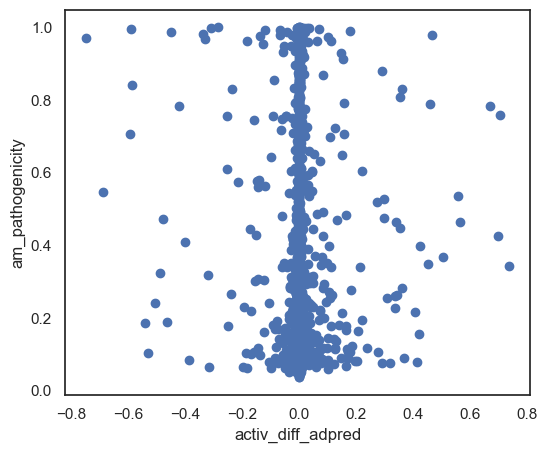

In [233]:
plot_with_am("adpred")

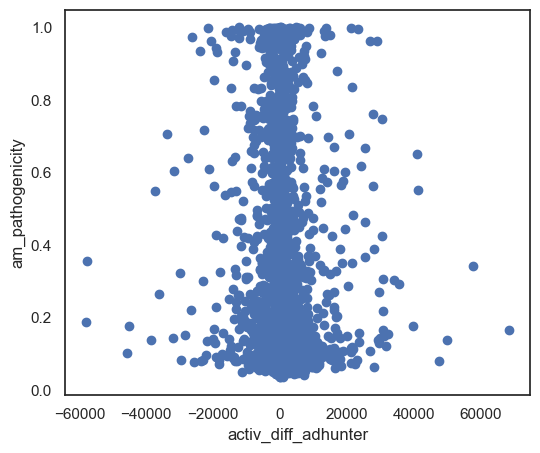

In [234]:
plot_with_am("adhunter")

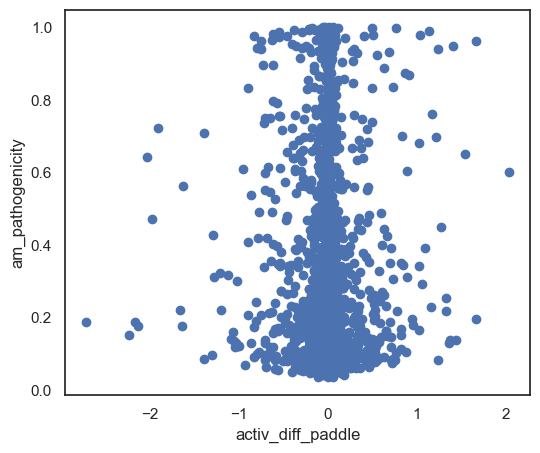

In [235]:
plot_with_am("paddle")

---
Histograms of difference

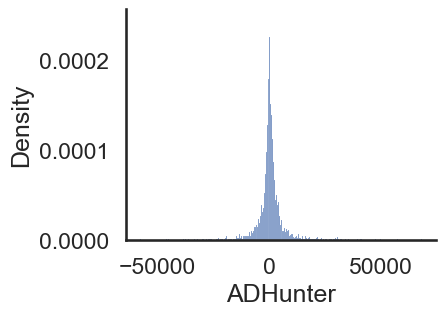

In [249]:
sns.set_context('talk')
sns.histplot(summary["activ_diff_adhunter"], stat = "density")
sns.despine()
plt.xlabel("ADHunter");

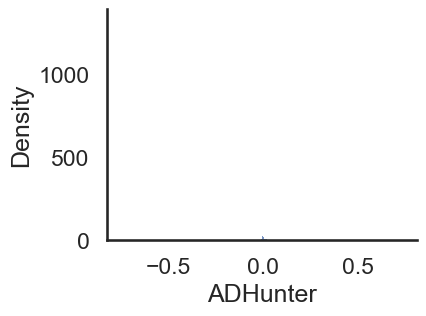

In [250]:
sns.set_context('talk')
sns.histplot(summary["activ_diff_adpred"], stat = "density")
sns.despine()
plt.xlabel("ADHunter");

<Axes: xlabel='activ_diff_paddle', ylabel='Density'>

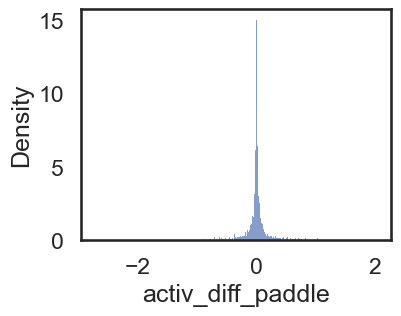

In [251]:
sns.histplot(summary["activ_diff_paddle"], stat = "density")

---
Variance vs mean

In [252]:
adpred_var_mean = adpred_results_summary.groupby(["orig_AA", "new_AA"]).agg(['mean', 'var', 'count']).reset_index()
adpred_var_mean

orig_AA new_AA activ_diff_adpred                    
                                mean           var count
0         A      D          0.008929  4.455938e-04     9
1         A      E          0.004104  3.785887e-05     3
2         A      G          0.000153  1.510794e-07    16
3         A      P         -0.000459  2.233655e-06    17
4         A      S          0.000027  5.623848e-06    31
..      ...    ...               ...           ...   ...
138       Y      D         -0.000634           NaN     1
139       Y      F          0.041993  3.416960e-03     5
140       Y      H         -0.031903  2.883815e-03    10
141       Y      N         -0.008724  1.159032e-05     3
142       Y      S         -0.016141  3.787362e-04     4

[143 rows x 5 columns]

In [253]:
paddle_var_mean = paddle_results_summary.groupby(["orig_AA", "new_AA"]).agg(['mean', 'var', 'count']).reset_index()
paddle_var_mean

orig_AA new_AA activ_diff_paddle                
                                mean       var count
0         A      D          0.210569  0.297544     9
1         A      E          0.260471  0.016390     3
2         A      G          0.038074  0.006840    21
3         A      P         -0.000410  0.005791    20
4         A      S          0.043346  0.005993    35
..      ...    ...               ...       ...   ...
139       Y      D         -0.031954       NaN     1
140       Y      F          0.124197  0.031978     5
141       Y      H         -0.102076  0.022007    12
142       Y      N         -0.318362  0.175695     3
143       Y      S         -0.248174  0.027490     4

[144 rows x 5 columns]

In [254]:
adhunter_var_mean = adhunter_results_summary.groupby(["orig_AA", "new_AA"]).agg(['mean', 'var', 'count']).reset_index()
adhunter_var_mean

orig_AA new_AA activ_diff_adhunter                    
                                  mean           var count
0         A      D         4835.516927  1.026890e+08     9
1         A      E         6607.691406  2.728940e+08     3
2         A      G         -151.670573  6.999656e+06    21
3         A      P         -821.702734  8.144688e+06    20
4         A      S        -1388.499414  1.693943e+07    35
..      ...    ...                 ...           ...   ...
139       Y      D        -1747.054688           NaN     1
140       Y      F         4323.586719  1.295284e+07     5
141       Y      H        -6726.673503  6.793798e+07    12
142       Y      N       -23553.691406  5.215950e+07     3
143       Y      S        -9960.533203  1.527229e+07     4

[144 rows x 5 columns]

In [255]:
def mean_var_scatter(var_mean_df, pred_name):
    df = var_mean_df.copy(deep = True)
    df.columns = df.columns.get_level_values(1)
    df = df.sort_values(by = "count")
    plt.scatter(data = df, x = "mean", y = "var", c = "count")
    plt.xlabel("Mean Difference")
    plt.ylabel("Variance")
    plt.title(pred_name + " Activity Predictions per Residue Change")
    plt.colorbar(label = "count");

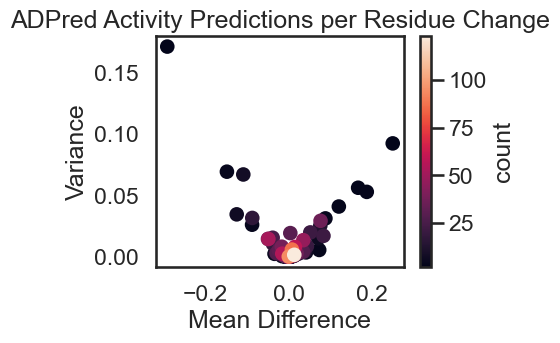

In [256]:
mean_var_scatter(adpred_var_mean, "ADPred")

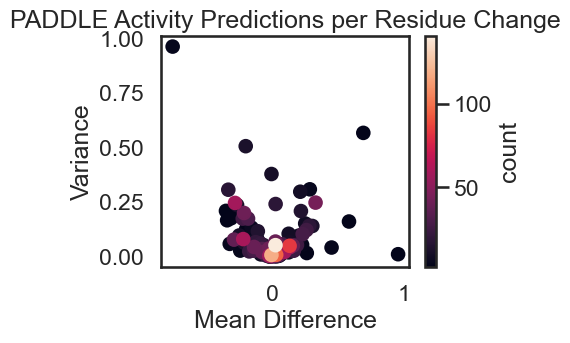

In [257]:
mean_var_scatter(paddle_var_mean, "PADDLE")

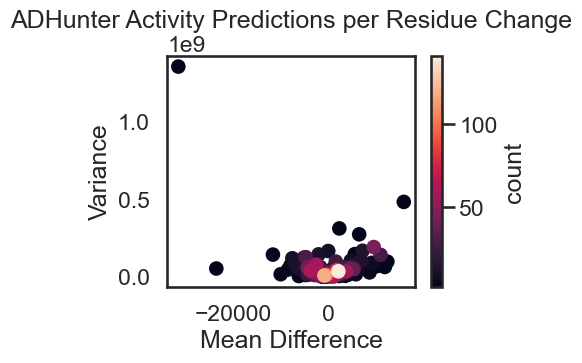

In [258]:
mean_var_scatter(adhunter_var_mean, "ADHunter")

---
Repeating with normalizing mean difference curves for each

In [259]:
def normalize(col):
    return (col - np.mean(col)) / np.std(col)

In [260]:
adpred_results_summary["norm_activ_diff_adpred"] = normalize(adpred_results_summary["activ_diff_adpred"])
adpred_results_summary

,orig_AA,new_AA,activ_diff_adpred,norm_activ_diff_adpred
1494,R,Q,1.226192e-04,-0.029272
1495,V,I,1.791068e-05,-0.030730
1496,V,F,1.221165e-04,-0.029279
1497,G,E,2.375223e-05,-0.030649
1498,T,I,5.111700e-04,-0.023860
...,...,...,...,...
1551,D,H,-3.851060e-03,-0.084618
1552,Q,L,1.116895e-02,0.124583
1553,Q,R,-2.347350e-03,-0.063674
1554,A,T,-1.801600e-04,-0.033489


In [261]:
adhunter_results_summary["norm_activ_diff_adhunter"] = normalize(adhunter_results_summary["activ_diff_adhunter"])
adhunter_results_summary

,orig_AA,new_AA,activ_diff_adhunter,norm_activ_diff_adhunter
0,E,D,259.750000,-0.021026
1,P,S,-913.535156,-0.195823
2,D,N,-1440.195312,-0.274285
3,P,L,-2773.800781,-0.472967
4,P,T,-324.066406,-0.108003
...,...,...,...,...
30,P,A,-6619.335938,-1.045879
31,H,Y,573.941406,0.025783
32,S,C,-3425.875000,-0.570114
33,A,T,-2351.886719,-0.410110


In [262]:
paddle_results_summary["norm_activ_diff_paddle"] = normalize(paddle_results_summary["activ_diff_paddle"])
paddle_results_summary

,orig_AA,new_AA,activ_diff_paddle,norm_activ_diff_paddle
0,E,D,0.018050,0.092380
1,P,S,-0.005857,0.002209
2,D,N,-0.053559,-0.177718
3,P,L,-0.011510,-0.019116
4,P,T,0.004007,0.039414
...,...,...,...,...
30,P,A,0.028733,0.132676
31,H,Y,0.042604,0.184996
32,S,C,-0.096152,-0.338370
33,A,T,0.123726,0.490973


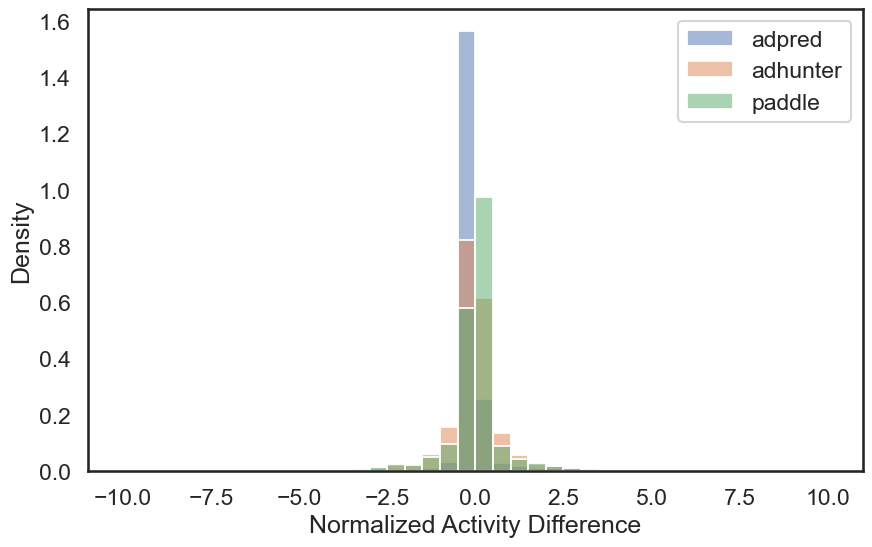

In [263]:
plt.figure(figsize=(10,6))
sns.histplot(adpred_results_summary["norm_activ_diff_adpred"], stat = "density", bins = np.arange(-10, 10.5, 0.5), alpha = 0.5, label = "adpred");
sns.histplot(adhunter_results_summary["norm_activ_diff_adhunter"], stat = "density", bins = np.arange(-10, 10.5, 0.5), alpha = 0.5, label = "adhunter");
sns.histplot(paddle_results_summary["norm_activ_diff_paddle"], stat = "density", bins = np.arange(-10, 10.5, 0.5), alpha = 0.5, label = "paddle");
plt.xlabel("Normalized Activity Difference")
plt.legend();

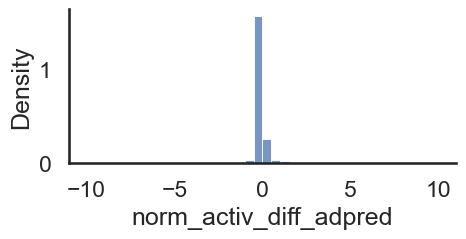

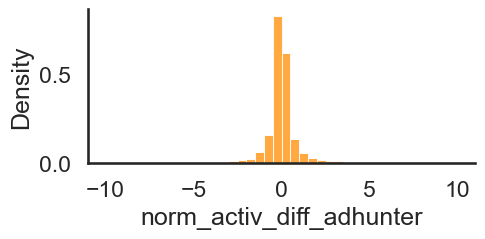

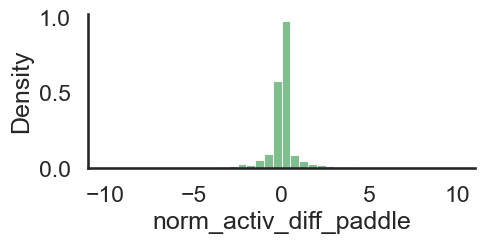

In [268]:
plt.figure(figsize=(5,2))
sns.histplot(adpred_results_summary["norm_activ_diff_adpred"], stat = "density", bins = np.arange(-10, 10.5, 0.5), label = "adpred");
sns.despine()
plt.show();

plt.figure(figsize=(5,2))
sns.histplot(adhunter_results_summary["norm_activ_diff_adhunter"], stat = "density", color = "darkorange", bins = np.arange(-10, 10.5, 0.5), label = "adhunter");
sns.despine()
plt.show();

plt.figure(figsize=(5,2))
sns.histplot(paddle_results_summary["norm_activ_diff_paddle"], stat = "density", color = "g", bins = np.arange(-10, 10.5, 0.5), label = "paddle");
sns.despine()


In [307]:
def plot_two_norm(x, y, adpred_input = False): 
    x = "norm_activ_diff_" + x
    y = "norm_activ_diff_" + y
    plt.scatter(data = summary, x = x, y = y, s = 0.25, alpha = 0.5)
    plt.xlabel(x)
    plt.ylabel(y)

    if adpred_input:
        r, p = spearmanr(summary.dropna()[x], summary.dropna()[y])
        print(r)
    else:
        r, p = spearmanr(summary[x], summary[y])
        print(r)

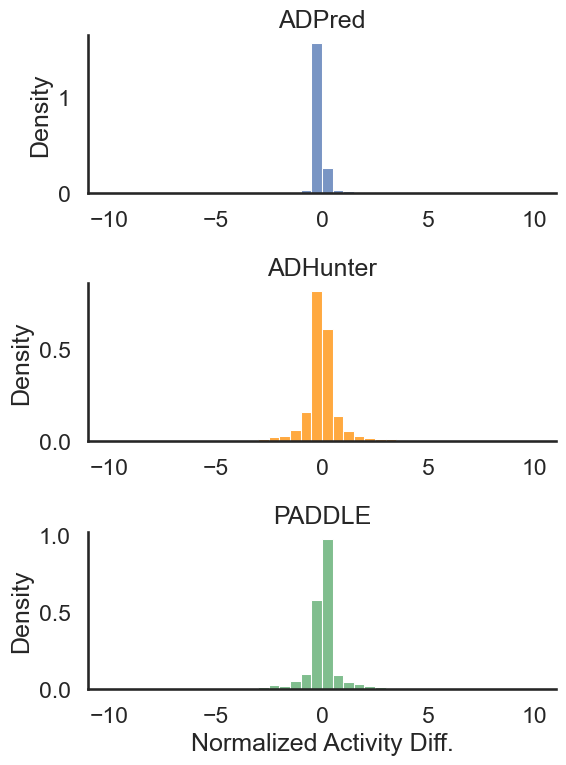

In [288]:
sns.set_context('talk')

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(6, 8))

# Adpred histogram
sns.histplot(adpred_results_summary["norm_activ_diff_adpred"], 
             stat="density", 
             bins=np.arange(-10, 10.5, 0.5), 
             ax=axes[0], 
             label="adpred")
axes[0].set_title("ADPred")
axes[0].set_xlabel("")
sns.despine(ax=axes[0])

# Adhunter histogram
sns.histplot(adhunter_results_summary["norm_activ_diff_adhunter"], 
             stat="density", 
             color="darkorange", 
             bins=np.arange(-10, 10.5, 0.5), 
             ax=axes[1], 
             label="adhunter")
axes[1].set_title("ADHunter")
axes[1].set_xlabel("")
sns.despine(ax=axes[1])

# Paddle histogram
sns.histplot(paddle_results_summary["norm_activ_diff_paddle"], 
             stat="density", 
             color="g", 
             bins=np.arange(-10, 10.5, 0.5), 
             ax=axes[2], 
             label="paddle")
axes[2].set_title("PADDLE")
axes[2].set_xlabel("Normalized Activity Diff.")

sns.despine(ax=axes[2])

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [ ]:
summary

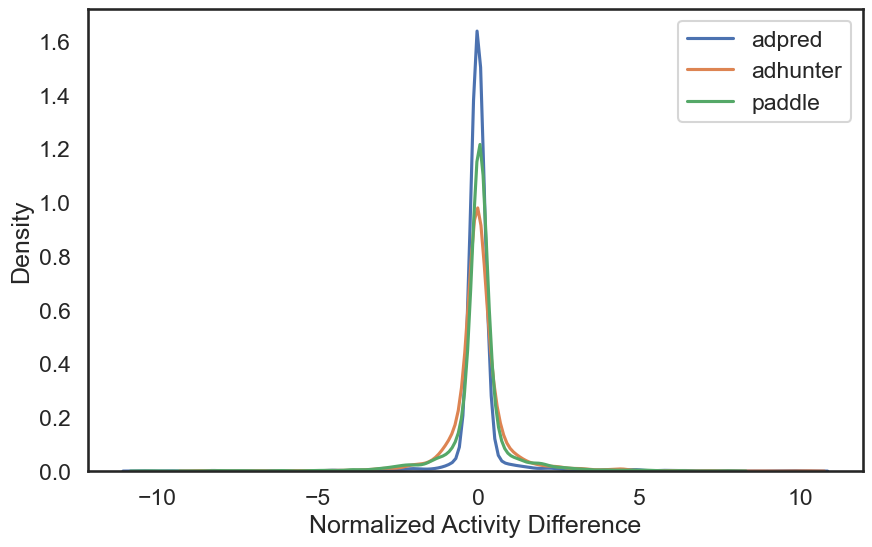

In [265]:
plt.figure(figsize=(10,6))
sns.kdeplot(adpred_results_summary["norm_activ_diff_adpred"], label = "adpred");

sns.kdeplot(adhunter_results_summary["norm_activ_diff_adhunter"], label = "adhunter");
sns.kdeplot(paddle_results_summary["norm_activ_diff_paddle"], label = "paddle");
plt.xlabel("Normalized Activity Difference")
plt.legend();

In [ ]:
plt.figure(figsize=(3,3), dpi = 300)
sns.histplot(adpred_results_summary["norm_activ_diff_adpred"], stat = "density", bins = np.arange(-10, 10.5, 0.5), label = "adpred");
plt.xlabel("ADPred Norm. Activity Change")
plt.show();

plt.figure(figsize=(3,3), dpi = 300)
sns.histplot(adhunter_results_summary["norm_activ_diff_adhunter"], stat = "density", bins = np.arange(-10, 10.5, 0.5), label = "adhunter");
plt.xlabel("ADHunter Norm. Activity Change")
plt.show();

plt.figure(figsize=(3,3), dpi = 300)
sns.histplot(paddle_results_summary["norm_activ_diff_paddle"], stat = "density", bins = np.arange(-10, 10.5, 0.5), label = "paddle");
plt.xlabel("PADDLE Norm. Activity Change")


In [314]:
# To send to pooja
to_send = summary[["var", "var_pred_paddle", "wt_pred_paddle", "var_pred_adhunter", "wt_pred_adhunter", "var_pos_adpred_activity", "ref_pos_adpred_activity"]]
to_send.to_csv("../output/summary_paddle_adhunter_adpred_pt_vars.csv")
to_send

,var,var_pred_paddle,wt_pred_paddle,var_pred_adhunter,wt_pred_adhunter,var_pos_adpred_activity,ref_pos_adpred_activity
0,SRCAP_Q6ZRS2_AD_198-1445|g.30710822A>T(p.Glu40...,0.147968,0.129918,24071.039062,23811.289062,NaN,NaN
1,SRCAP_Q6ZRS2_AD_198-1445|g.30721233C>T(p.Pro11...,-0.181365,-0.175508,42768.371094,43681.906250,NaN,NaN
2,SRCAP_Q6ZRS2_AD_198-1445|g.30721455G>A(p.Asp11...,-0.179097,-0.125538,46607.949219,48048.144531,NaN,NaN
3,SRCAP_Q6ZRS2_AD_198-1445|g.30723605C>T(p.Pro13...,-0.034244,-0.022734,29713.363281,32487.164062,NaN,NaN
4,SRCAP_Q6ZRS2_AD_198-1445|g.30720897C>A(p.Pro10...,-0.132803,-0.136810,38172.605469,38496.671875,NaN,NaN
...,...,...,...,...,...,...,...
3005,NKX2-2_O95096_AD_220-273|g.21511967G>C(p.Pro26...,0.265297,0.236564,49325.363281,55944.699219,0.010054,0.009444
3006,NKX2-2_O95096_AD_220-273|g.21512015G>A(p.His24...,0.279168,0.236564,52713.988281,52140.046875,0.012618,0.003549
3007,NKX2-2_O95096_AD_220-273|g.21512041G>C(p.Ser23...,0.101297,0.197448,48869.820312,52295.695312,0.025123,0.016844
3008,NKX2-2_O95096_AD_220-273|g.21512072C>T(p.Ala22...,0.321174,0.197448,49943.808594,52295.695312,0.016251,0.017796
